In [2]:
import string
import math
import copy
import time

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import datasets

In [3]:

from skimage import color
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean

In [4]:
import keras
from keras.layers import concatenate
from keras.utils import get_file

from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

from keras import layers, Model
from keras.layers import TextVectorization, LeakyReLU, Conv2DTranspose, Embedding, Bidirectional, Reshape, Dense, BatchNormalization, LSTM
from keras.layers import GRU, Conv2D, MaxPooling2D, Flatten, UpSampling2D, Dropout, MultiHeadAttention, LayerNormalization, Add, StringLookup
from keras import Sequential, Input
from keras.models import save_model, load_model

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

tf.config.run_functions_eagerly(True)
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [5]:
from os import listdir
import sys
import os

In [19]:
#function for loading training images and masks via path to the folder with images
def load_images(image_path, mask_path):
    images = []
    masks = []
    #downloading every image in folder
    for i in listdir(image_path):
        image = io.imread(image_path + "\\" + str(i))
        #this is for the png case
        #image = color.rgba2rgb(image)
        #resize to 64x64
        image_res = resize(image,  (64, 64), anti_aliasing=False)
        #making it into -1 - 1 scale
        image_res = image_res*2 - 1
        images.append(image_res)
    for i in listdir(mask_path):
        image = io.imread(mask_path + "\\" + str(i))
        image_res = resize(image,  (64, 64), anti_aliasing=False)
        masks.append(image_res)
    #to numpy to shove them into model
    images=np.asarray(images).astype(np.float32)
    masks=np.asarray(masks).astype(np.float32)
    return images, masks

In [20]:
images, masks = load_images("fish\\image","fish\\mask")

In [8]:
#checking whether the shape of the image is correct
images[0].shape

(64, 64, 3)

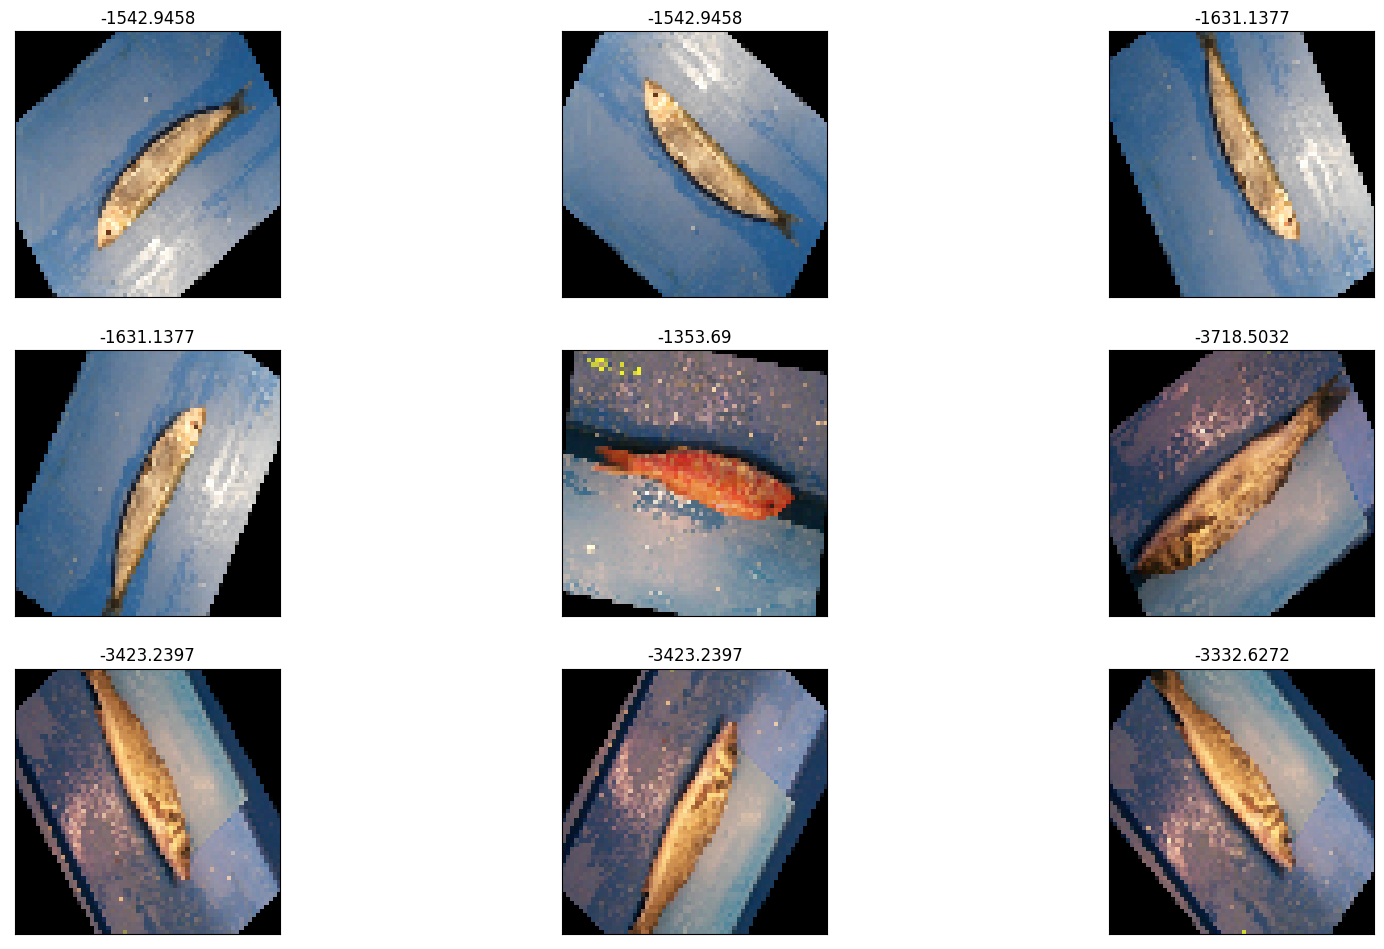

In [9]:
#plotting images to show them as an example. Calculating sum in case we'll need to search for anomalies
#actually, i just pasted the code from my notebook from other semester where i did searched for anomalies
fig = plt.figure(figsize=(20,20))
for row in range(3):
    for column in range(3):
        i = row * 3 + column
        if i>len(images)-1:
            break                   
        ax = fig.add_subplot(5, 3, i+1)
        ax.set_title(str(np.sum(images[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((images[i]+1)/2)

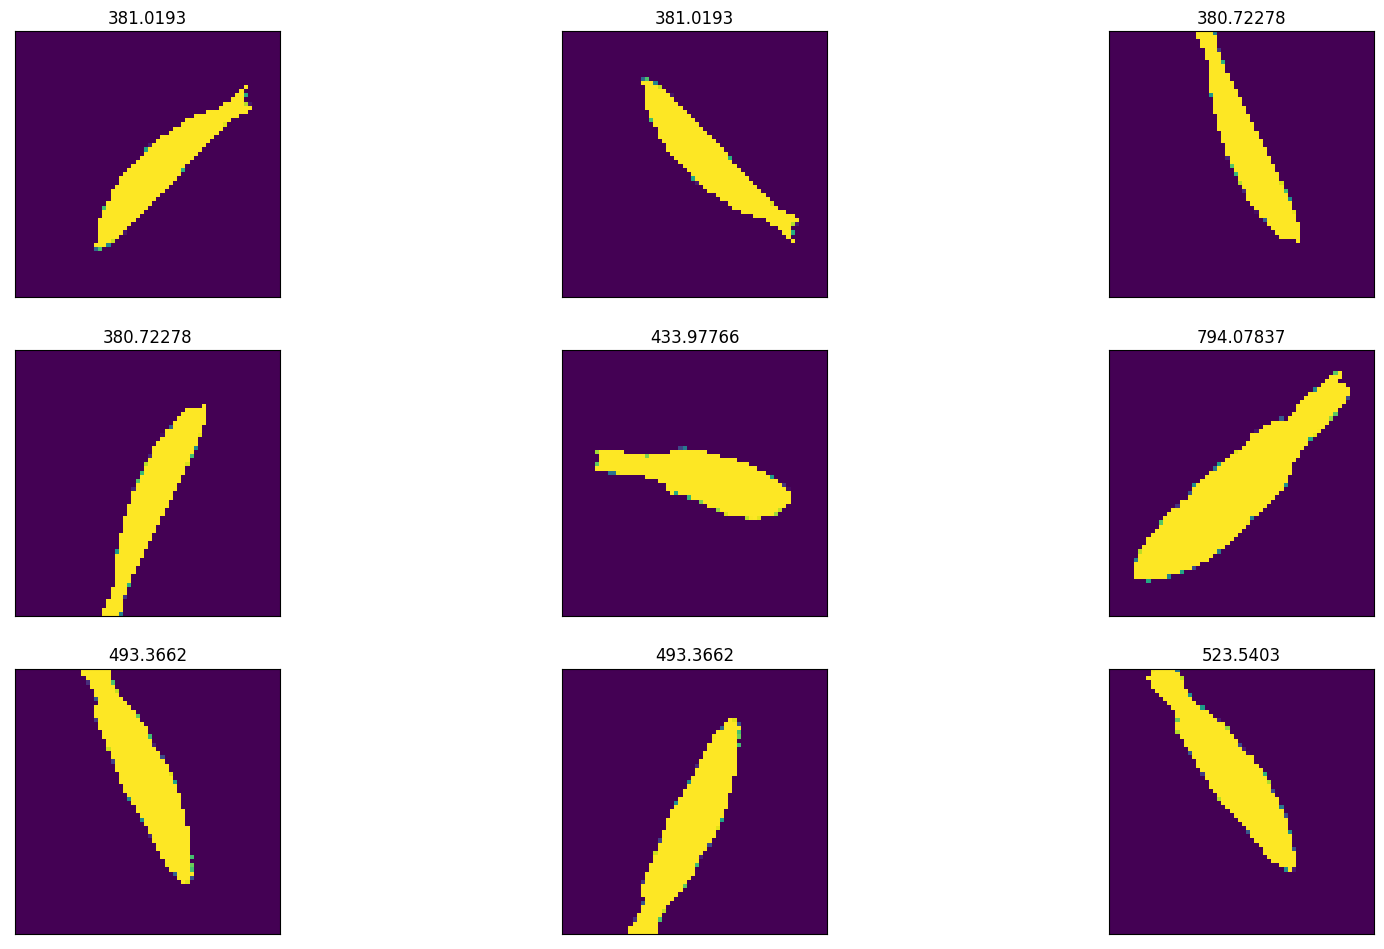

In [9]:
#same but with masks
fig = plt.figure(figsize=(20,20))
for row in range(3):
    for column in range(3):
        i = row * 3 + column
        if i>len(images)-1:
            break                   
        ax = fig.add_subplot(5, 3, i+1)
        ax.set_title(str(np.sum(masks[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(masks[i])

In [10]:
#defining our model. We are using simplified unet architecture - same idea, less of everything so it would fit on my 1050
def unet_model(optim):
    #2 convolutions, 1 downsample. Repeat 2 times. It's 3 convolutions in original architecture
    #downsampling, getting features
    input_1 =  Input(shape=(64, 64, 3))
    conv_0 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(input_1)
    relu_0 = LeakyReLU(alpha=0.2)(conv_0)
    conv_0_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(relu_0)
    relu_0_1 = LeakyReLU(alpha=0.2)(conv_0_1)
    down_sample_1 = MaxPooling2D((2, 2))(relu_0_1) #64x64 -> 32x32
    conv_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(down_sample_1)
    relu_1 = LeakyReLU(alpha=0.2)(conv_1)
    conv_1_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(relu_1)
    relu_1_1 = LeakyReLU(alpha=0.2)(conv_1_1)
    down_sample_2 = MaxPooling2D((2, 2))(relu_1_1)  #32x32 -> 16x16
    conv_2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(down_sample_2)
    relu_2 = LeakyReLU(alpha=0.2)(conv_2)
    conv_2_1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(relu_2)
    relu_2_1 = LeakyReLU(alpha=0.2)(conv_2_1)
    relu_2_1 = Dropout(0.2)(relu_2_1)
    #now reverse - same logic as with as unet architecture
    #upsampling, applying features
    up_sample_1 = concatenate([UpSampling2D((2, 2))(relu_2_1), relu_1_1], axis=-1) #32x32
    up_conv_1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up_sample_1)
    up_relu_1 = LeakyReLU(alpha=0.2)(up_conv_1)    
    up_conv_1_1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up_relu_1)
    up_relu_1_1 = LeakyReLU(alpha=0.2)(up_conv_1_1)
    
    up_sample_2 = concatenate([UpSampling2D((2, 2))(up_relu_1_1), relu_0_1], axis=-1) #64x64
    up_conv_2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up_sample_2)
    up_relu_2 = LeakyReLU(alpha=0.2)(up_conv_2)    
    up_conv_2_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up_relu_2)
    up_relu_2_1 = LeakyReLU(alpha=0.2)(up_conv_2_1)
    up_relu_2_1 = Dropout(0.2)(up_relu_2_1)
    #compressing everything into 64x64x1 array for our mask
    output_1 = Conv2D(filters=1, kernel_size=(3, 3), padding="same")(up_relu_2_1)
    output_1 = LeakyReLU(alpha=0.2)(output_1)
    unet_model = Model(inputs = input_1, outputs = output_1)
    unet_model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return unet_model


In [21]:
#turning off output class so it would predict silently
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [22]:
#function for printing images, masks and predicted masks
def print_prediction(images, masks):
    with HiddenPrints():
        #here we predict our masks
        predicted_masks = model.predict(images)
    fig = plt.figure(figsize=(20,20))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    #here we plot our images and masks
    for row in range(len(predicted_masks)):
        ax = fig.add_subplot(5, 3, row*3 + 1)
        ax.set_title(str(title[0]))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((images[row]+1)/2)
        
        ax = fig.add_subplot(5, 3, row*3 + 2)
        ax.set_title(str(title[1]))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(masks[row])
        
        ax = fig.add_subplot(5, 3, row*3 + 3)
        ax.set_title(str(title[2]))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(predicted_masks[row])
        
    

In [23]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [13]:
model = unet_model(optim)

In [14]:
#behold - tiny unet!
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['leaky_re_lu[0][0]']            
                                                                                              

N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


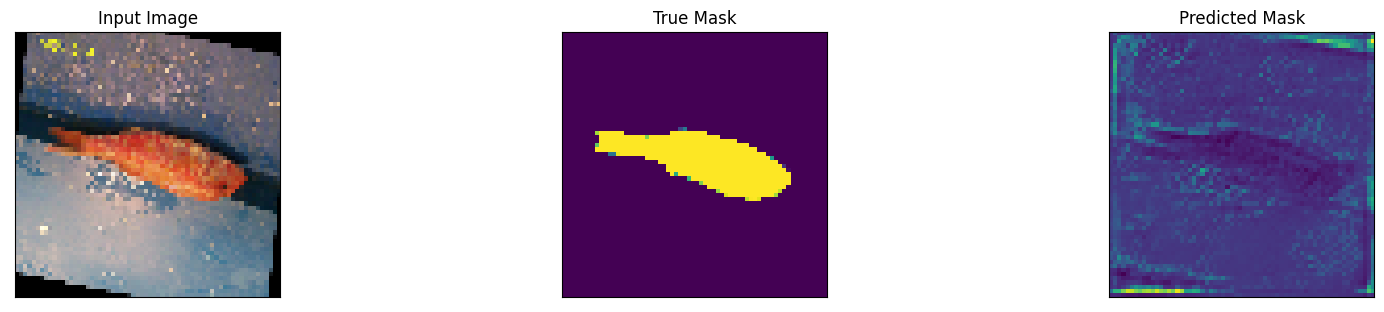

In [16]:
print_prediction(images[4:5], masks[4:5])

In [26]:
#for printing training history
def print_history(history):
    fig = plt.figure(figsize=(15,4))
    fig.add_subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.legend(['Training accuracy', 'Validation accuracy'])
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch Number')
    plt.ylabel('Accuracy')

    fig.add_subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training loss', 'Validation loss'])
    plt.title('Training and validation loss')
    plt.xlabel('Epoch Number')
    plt.ylabel('Loss')
    plt.show()

In [31]:
images.shape

(111, 64, 64, 3)

In [32]:

filepath = 'fishmodel3.h5'
#checkpoint to save only the best model. Tried to minimize loss - worked poorly.
#checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, save_best_only=True, mode='min')
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=0, save_best_only=True, mode='max')

In [33]:
history = model.fit(
    images, masks, 
    epochs=50,
    validation_split=0.2,
    callbacks=[checkpoint]
    #batch_size = 16
        )

Epoch 1/50
3/3 [==============================] - 6s 2s/step - loss: 0.5502 - accuracy: 0.8782 - val_loss: 0.3798 - val_accuracy: 0.8291
Epoch 2/50
3/3 [==============================] - 1s 408ms/step - loss: 0.3035 - accuracy: 0.8782 - val_loss: 0.3432 - val_accuracy: 0.8291
Epoch 3/50
3/3 [==============================] - 1s 396ms/step - loss: 0.2716 - accuracy: 0.8782 - val_loss: 0.3125 - val_accuracy: 0.8291
Epoch 4/50
3/3 [==============================] - 1s 552ms/step - loss: 0.2378 - accuracy: 0.8806 - val_loss: 0.2610 - val_accuracy: 0.8394
Epoch 5/50
3/3 [==============================] - 1s 447ms/step - loss: 0.2052 - accuracy: 0.9015 - val_loss: 0.2115 - val_accuracy: 0.8901
Epoch 6/50
3/3 [==============================] - 1s 437ms/step - loss: 0.1827 - accuracy: 0.9326 - val_loss: 0.2094 - val_accuracy: 0.8920
Epoch 7/50
3/3 [==============================] - 1s 452ms/step - loss: 0.1561 - accuracy: 0.9382 - val_loss: 0.1613 - val_accuracy: 0.9236
Epoch 8/50
3/3 [=======

In [20]:
imagelist = [images[5], images[16], images[30]]
masklist = [masks[5], masks[16], masks[30]]
imagelist = np.asarray(imagelist).astype(np.float32)
masklist = np.asarray(masklist).astype(np.float32)

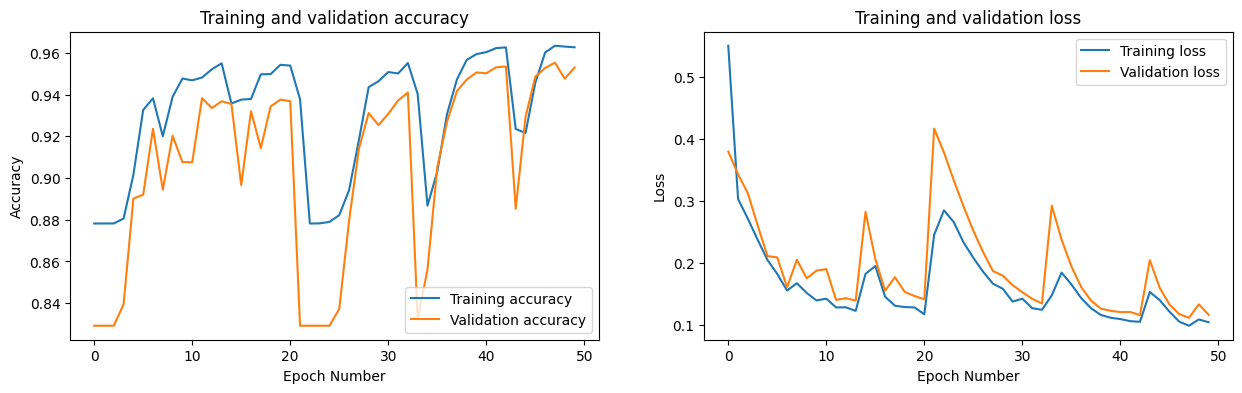

In [36]:
print_history(history)

In [18]:
#loading our model
model = keras.models.load_model('fishmodel3.h5')

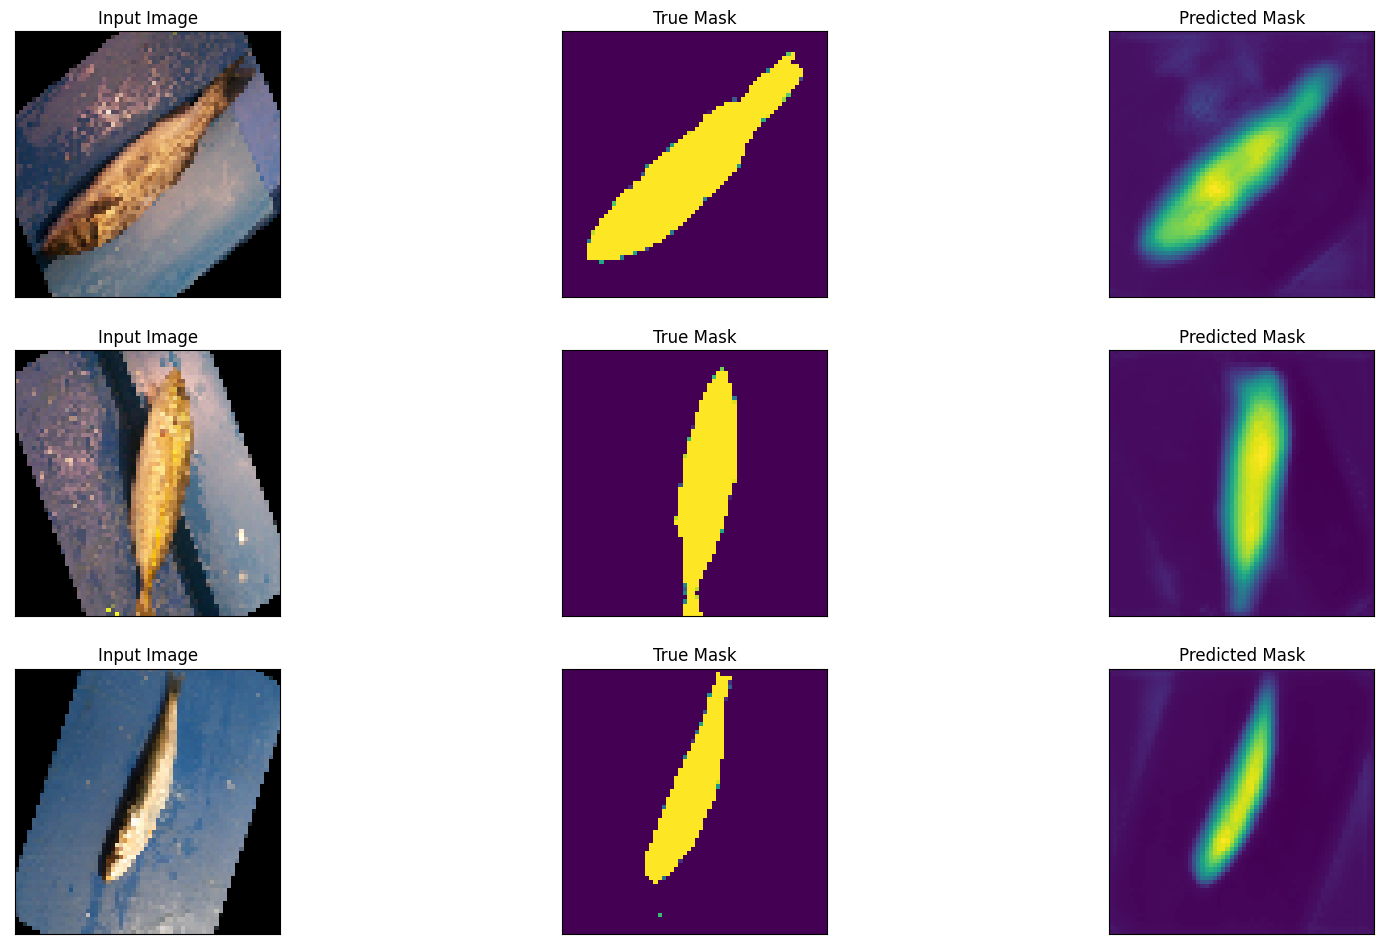

In [21]:
#example of what we got
print_prediction(imagelist, masklist)

In [22]:
#trying it out on images separate from our dataset. Works poorly with segmenting suddenly appearing white color
image = io.imread("fish\\00003.png")
image = color.rgba2rgb(image)
image_res = resize(image,  (64, 64), anti_aliasing=False)
imask = io.imread("fish\\00003m.png")
imask = resize(imask,  (64, 64), anti_aliasing=False)

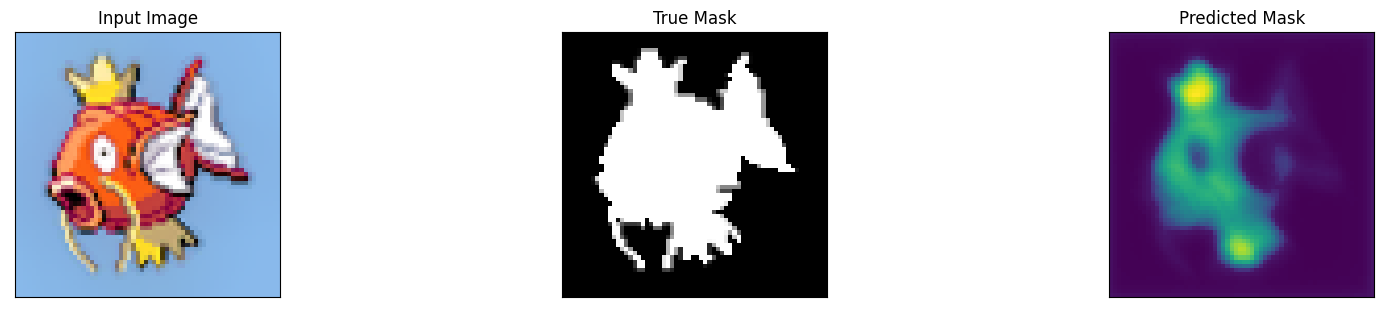

In [23]:
print_prediction(np.asarray([(image_res*2-1)]).astype(np.float32), np.asarray([imask]).astype(np.float32))

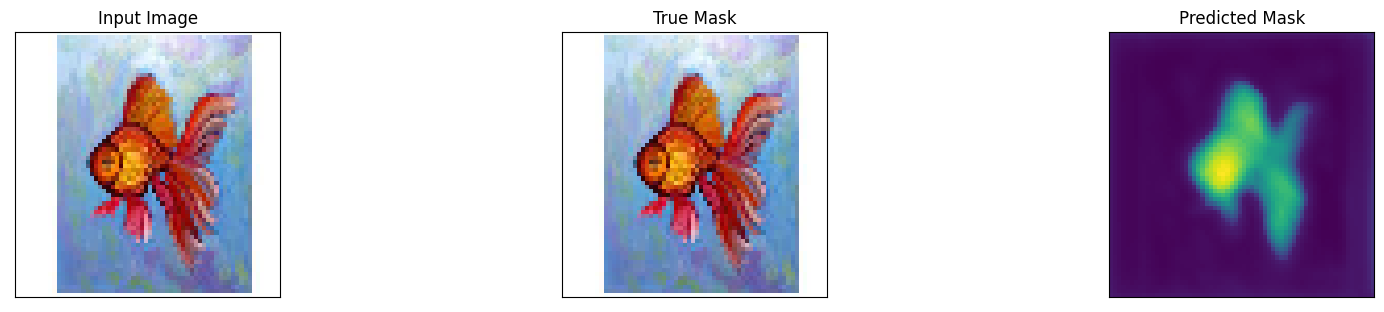

In [24]:
#another example
image = io.imread("fish\\fish.jpg")
#image = color.rgba2rgb(image)
image_res = resize(image,  (64, 64), anti_aliasing=False)
print_prediction(np.asarray([(image_res*2-1)]).astype(np.float32), np.asarray([image_res]).astype(np.float32))

In [31]:
#loading test images and masks
images, masks = load_images("fish\\test1","fish\\test1mask")

In [45]:
#okay accuracy
model.evaluate(images, masks)

2/2 [==============================] - 1s 646ms/step - loss: 0.1304 - accuracy: 0.9492


[0.13044659793376923, 0.9491825699806213]

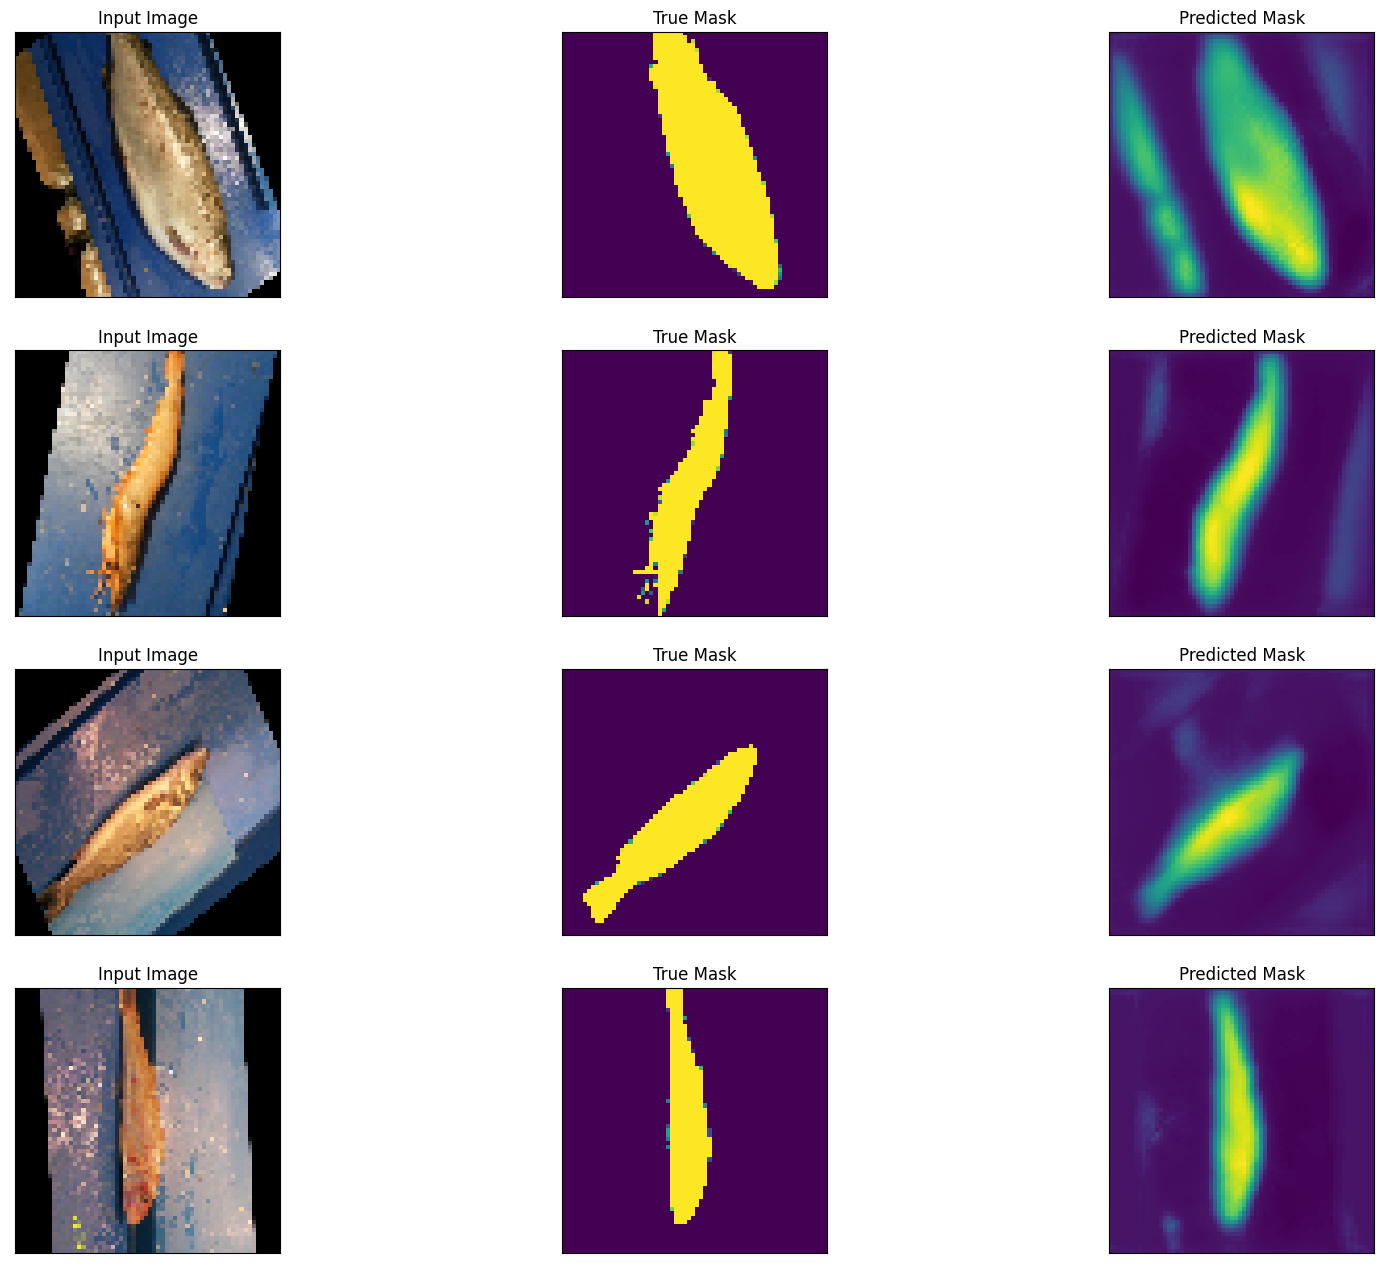

In [32]:
#example of work
print_prediction(images[12:16], masks[12:16])

In [12]:
#gradient-based pattern for adversarial attack
loss_object = keras.losses.BinaryCrossentropy()
def create_adversarial_pattern(input_image, input_mask):
    input_image = tf.convert_to_tensor(input_image, dtype=np.float32)
    input_mask = tf.convert_to_tensor(input_mask, dtype=np.float32)
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        #get loss
        loss = loss_object(input_mask, prediction)
    #tape loss
    gradient = tape.gradient(loss, input_image)
    #get sign of gradient
    signed_grad = tf.sign(gradient)
    return signed_grad

In [12]:
#getting gradient bit by bit - my vram is not enough for all at once
gradient = create_adversarial_pattern(images[0:-20], masks[0:-20])

In [13]:
gradient.shape

TensorShape([34, 64, 64, 3])

In [17]:
gradient2 = create_adversarial_pattern(images[-20:], masks[-20:])

In [19]:
gradient = tf.concat([gradient, gradient2], axis=0)

In [20]:
gradient.shape

TensorShape([54, 64, 64, 3])

In [22]:
gradient = np.asarray(gradient).astype(np.float32)

In [21]:
np.save('gradient64.npy', gradient)

In [26]:
gradient = np.load('gradient64.npy')

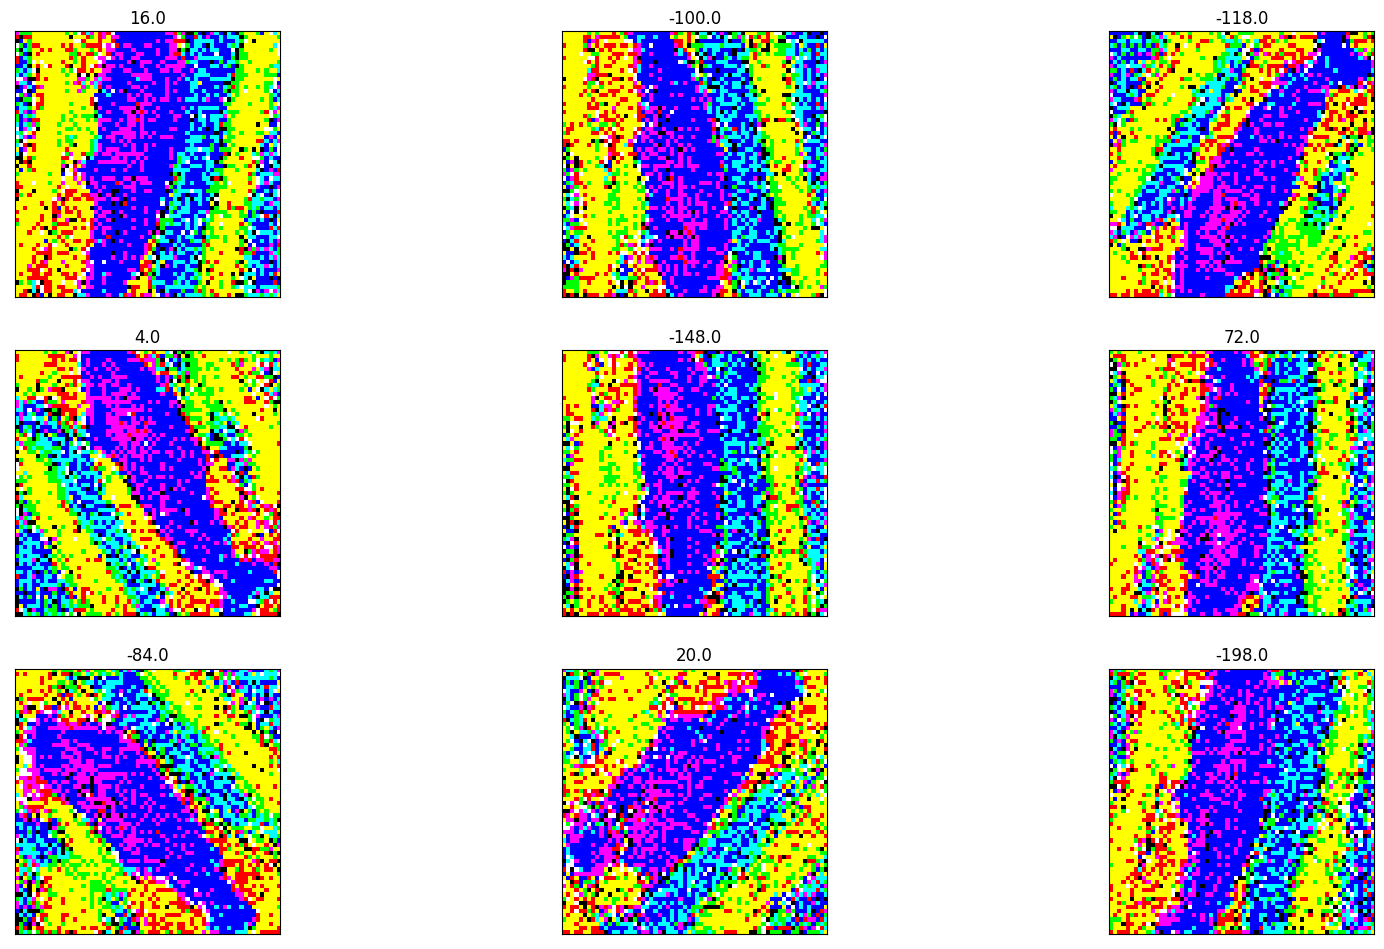

In [27]:
#showing off gradients
fig = plt.figure(figsize=(20,20))
for row in range(3):
    for column in range(3):
        i = row * 3 + column
        if i>len(images)-1:
            break                   
        ax = fig.add_subplot(5, 3, i+1)
        ax.set_title(str(np.sum(gradient[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((gradient[i]+1)/2)

In [33]:
#checking our model against adversarial attack
epsilons = [0, 0.01, 0.1, 0.15]
adversarials = []
for i, eps in enumerate(epsilons):
    adversarials.append(np.clip(images + eps*gradient, -1, 1))

In [33]:
for i in range(len(adversarials)):
    model.evaluate(adversarials[i], masks)

2/2 [==============================] - 0s 76ms/step - loss: 1.1380 - accuracy: 0.7665


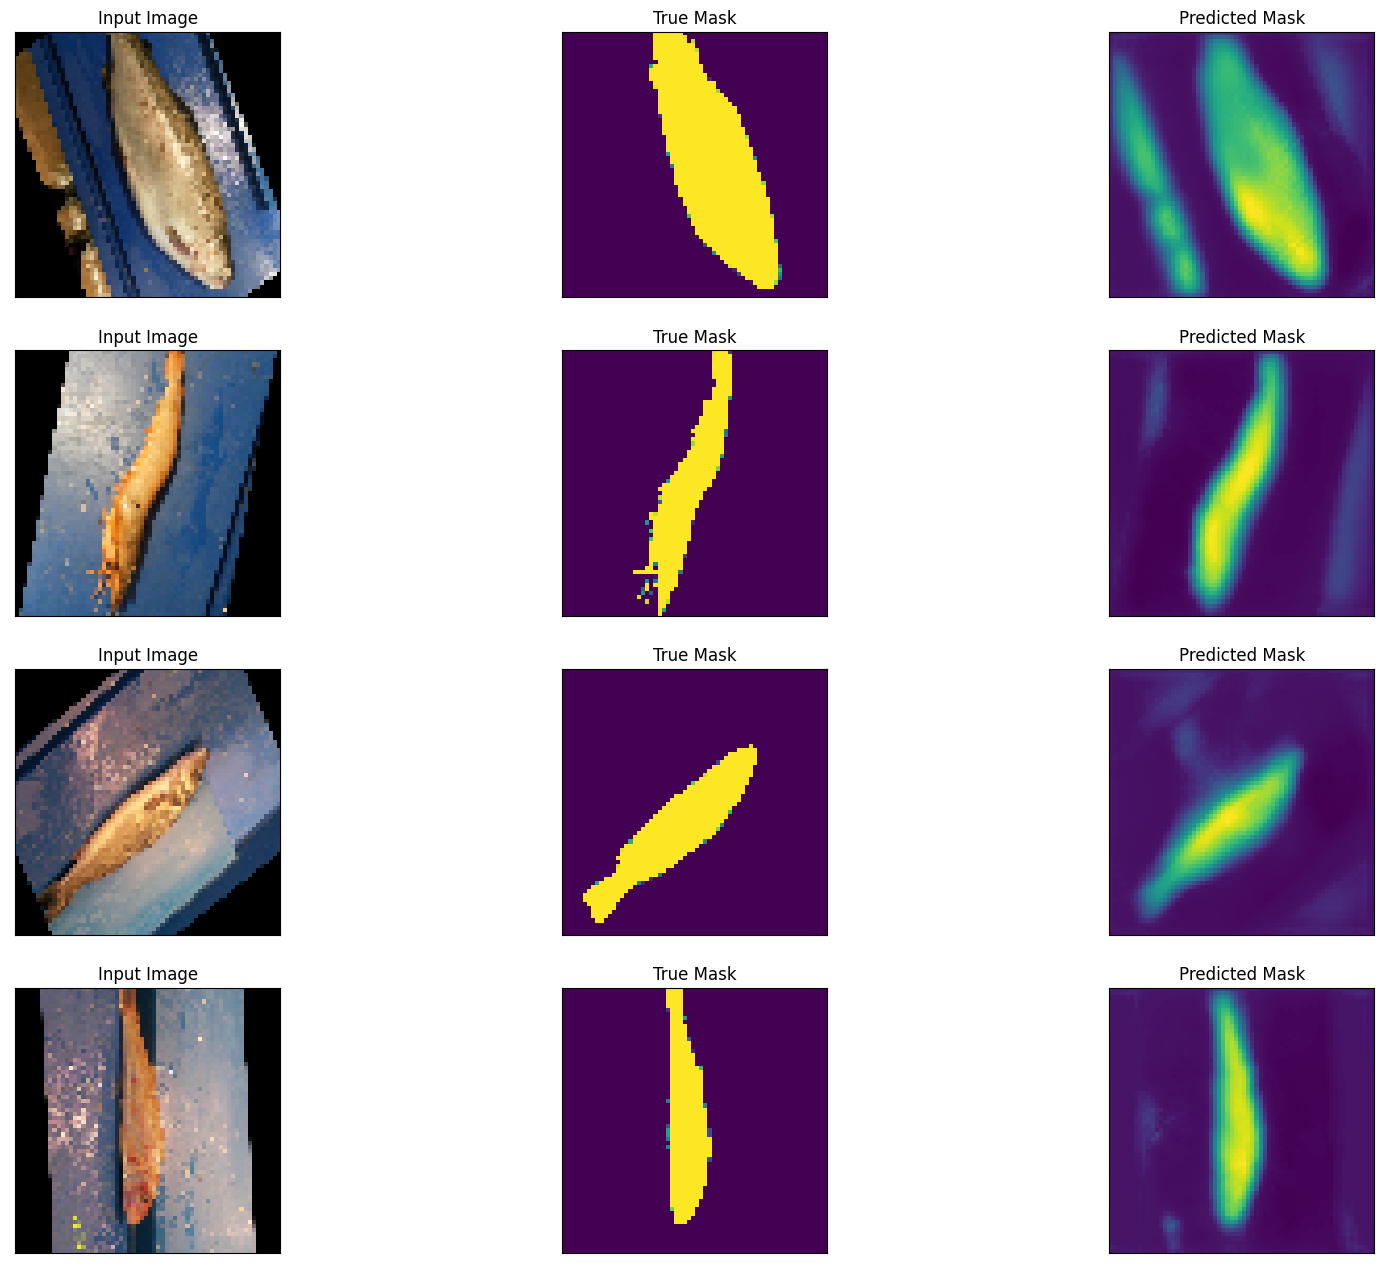

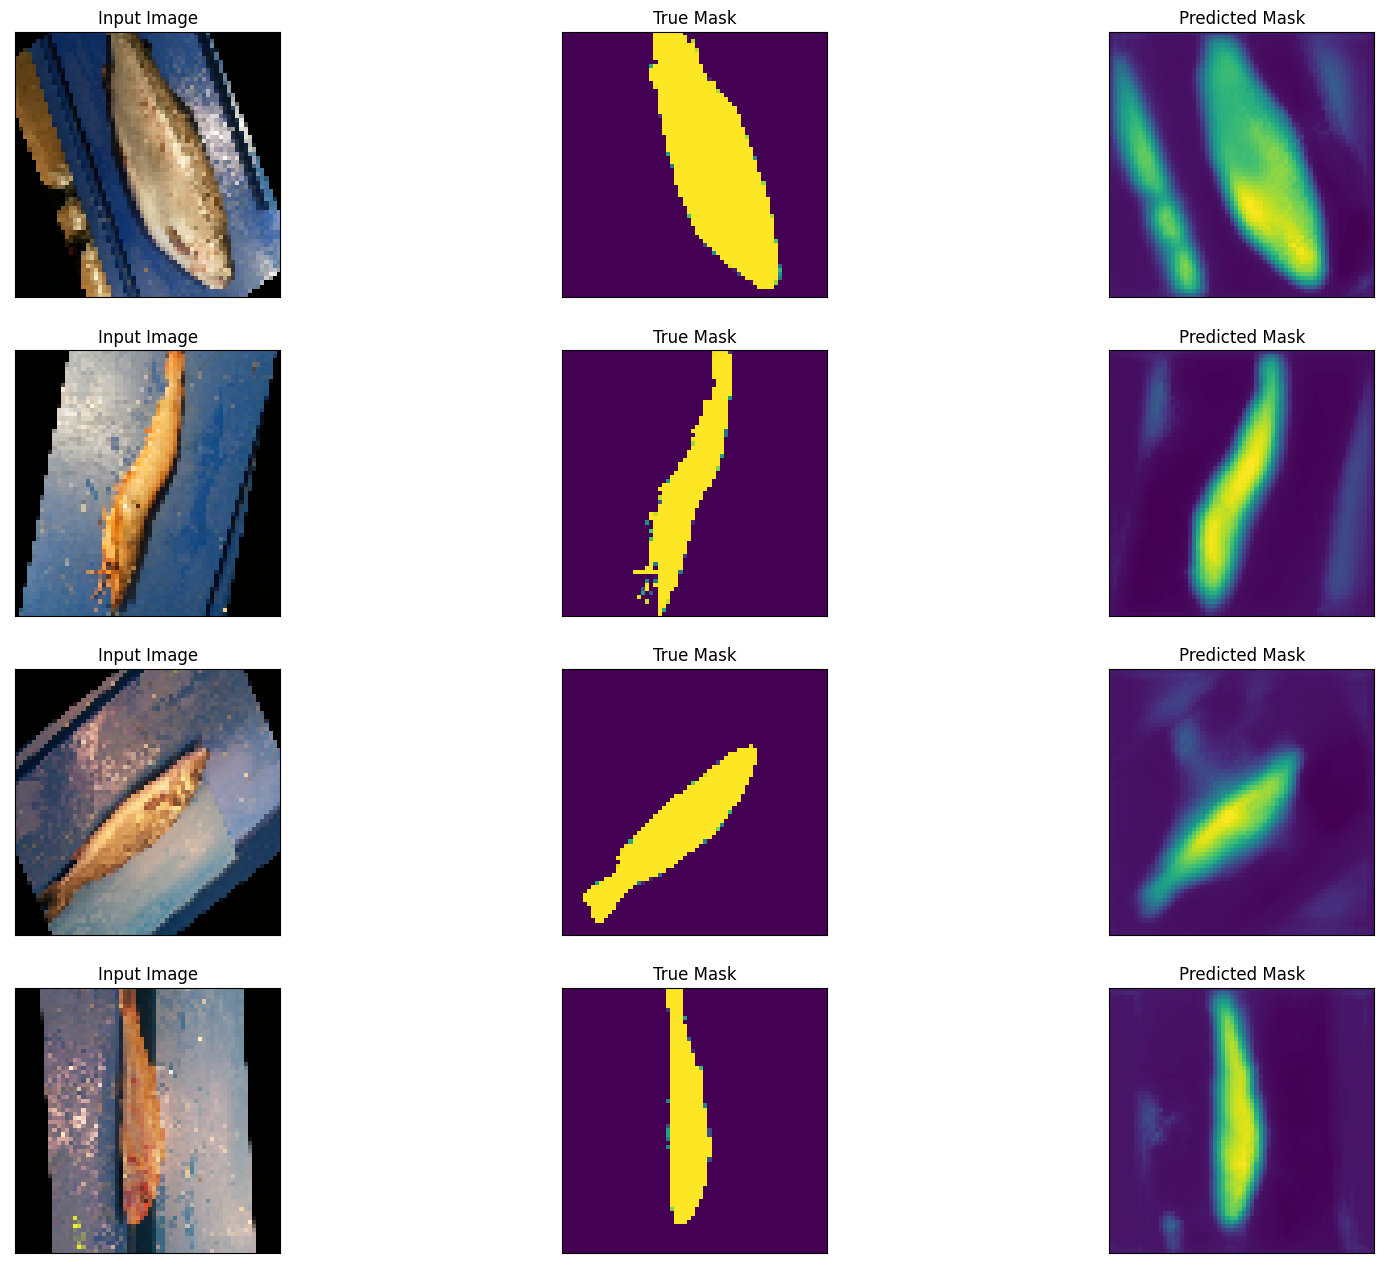

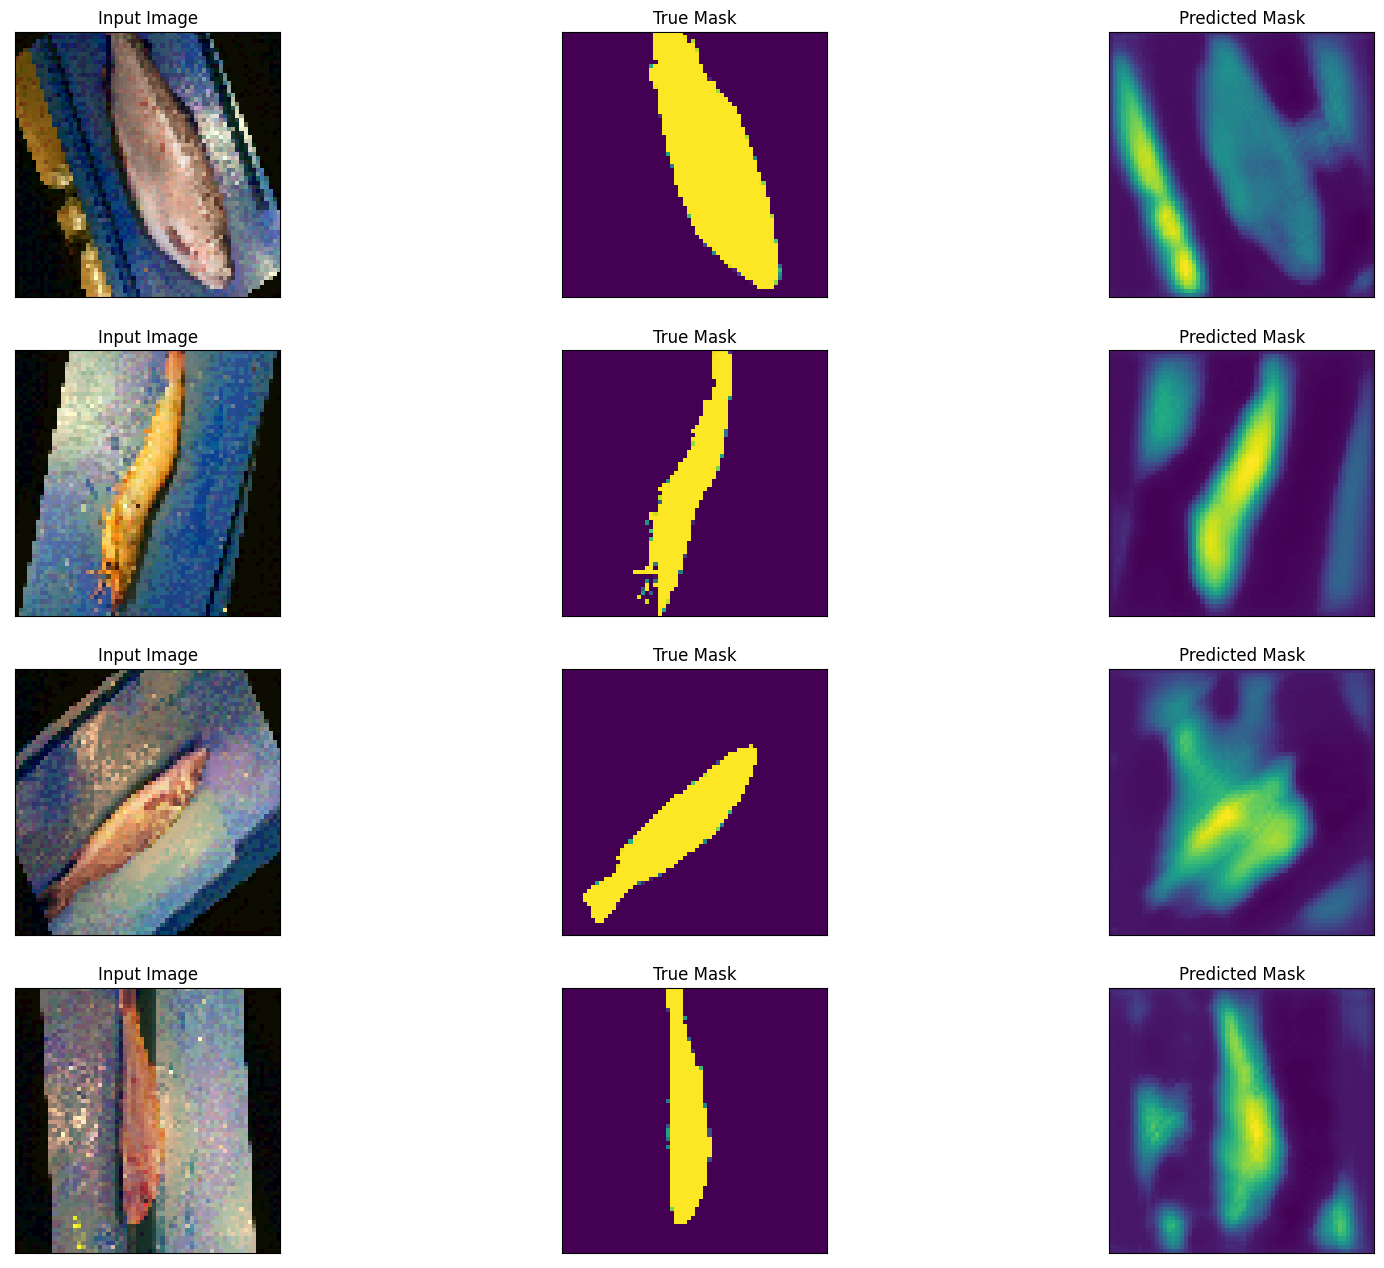

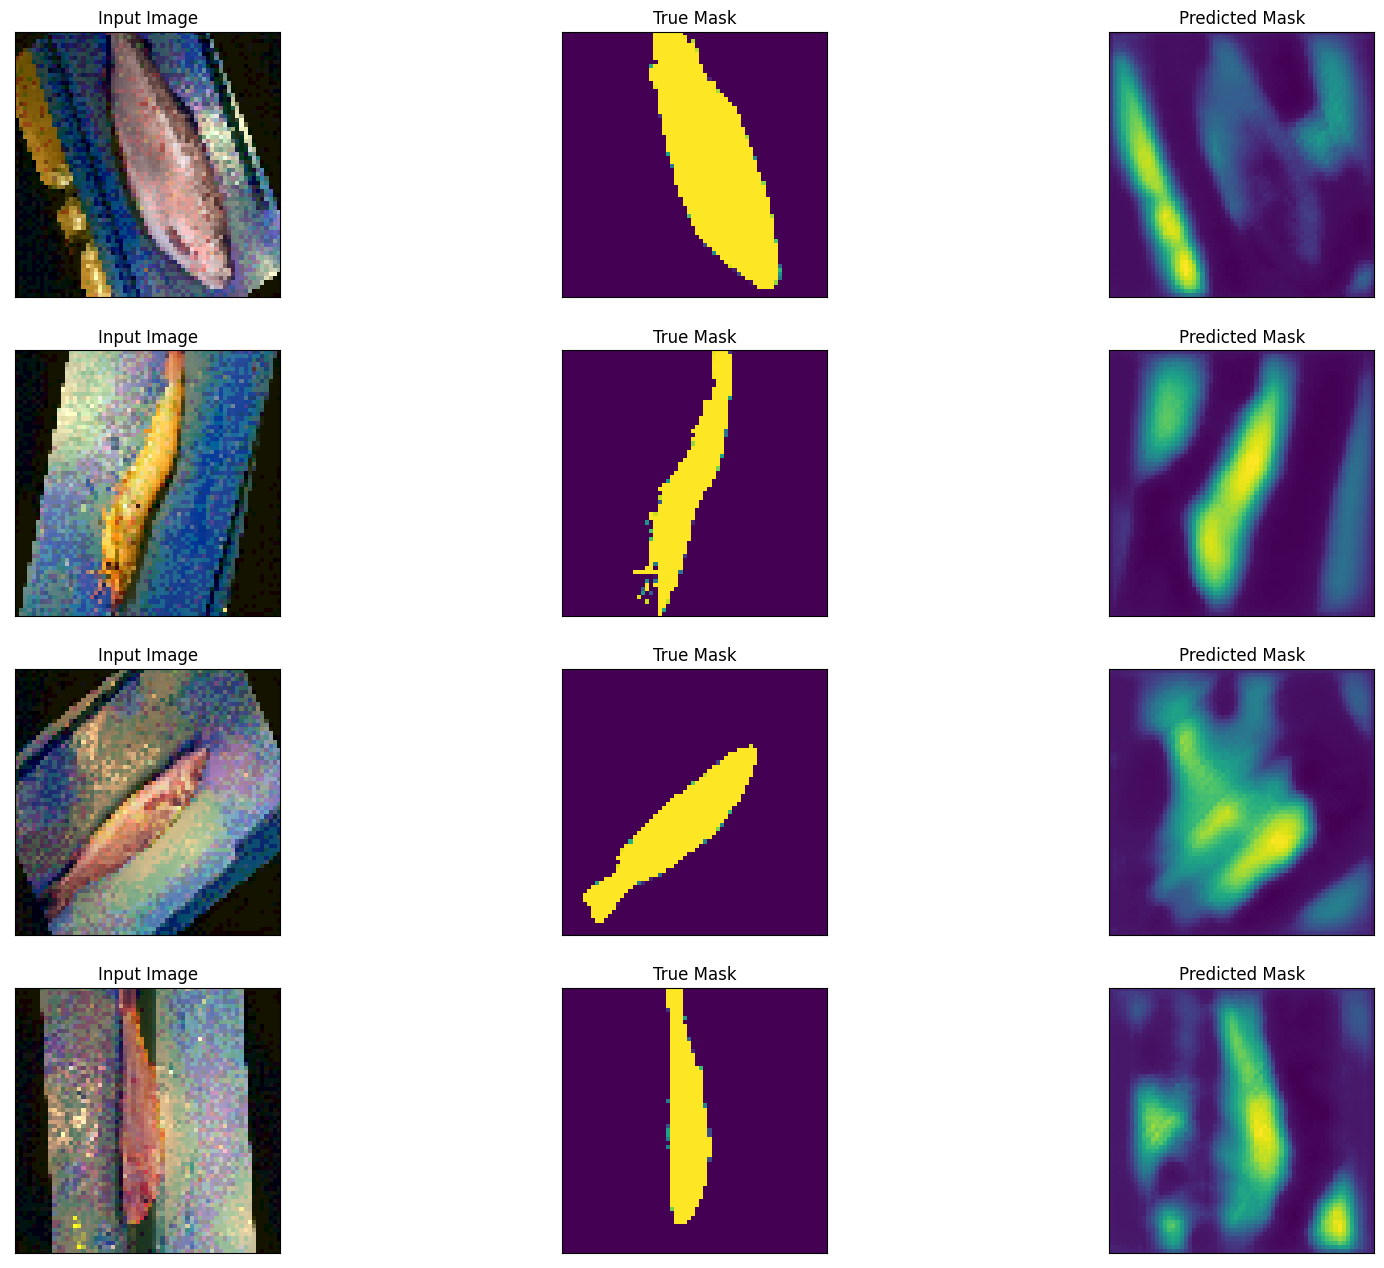

In [34]:
#visualized example
for i in range(len(adversarials)):
    print_prediction((adversarials[i])[12:16], masks[12:16])

In [10]:
#load function for training images for SRCNN
def load_sr_images(lr_path, hr_path):
    images = []
    hr_images = []
    for i in listdir(lr_path):
        image = io.imread(lr_path + "\\" + str(i))
        #image = color.rgba2rgb(image)
        image_res = resize(image,  (64, 64), anti_aliasing=False)
        image_res = image_res*2 - 1
        images.append(image_res)
    for i in listdir(hr_path):
        image = io.imread(hr_path + "\\" + str(i))
        #if image.shape != (64, 64, 3):
            #image = color.gray2rgb(image)
        image_res = resize(image,  (128, 128), anti_aliasing=False)
        image_res = image_res*2 - 1
        hr_images.append(image_res)
    images=np.asarray(images).astype(np.float32)
    hr_images=np.asarray(hr_images).astype(np.float32)
    return images, hr_images

In [11]:
lr_images, hr_images = load_sr_images("SRCNN\\LR","SRCNN\\HR")

In [12]:
#print SRCNN work
def print_SRCNN(images, masks):
    with HiddenPrints():
        predicted_masks = model_SRCNN.predict(images)
    fig = plt.figure(figsize=(20,20))
    title = ['Input Image', 'True HR', 'Predicted HR']
    for row in range(len(predicted_masks)):
        ax = fig.add_subplot(5, 3, row*3 + 1)
        ax.set_title(str(title[0]))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((images[row]+1)/2)
        
        ax = fig.add_subplot(5, 3, row*3 + 2)
        ax.set_title(str(title[1]))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((masks[row]+1)/2)
        
        ax = fig.add_subplot(5, 3, row*3 + 3)
        ax.set_title(str(title[2]))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((predicted_masks[row]+1)/2)

In [13]:
#mse loss for our model
def pixel_mse_loss(y_true,y_pred):
    return tf.reduce_mean( (y_true - y_pred) ** 2 )

In [14]:
def SRCNN(optim):
    #overbloated and strange SRCNN - bicubic interpolation + convolutions
    input_1 =  Input(shape=(64, 64, 3))
    #conv_0 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(input_1)
    relu_0 = LeakyReLU(alpha=0.2)(input_1)
    up_0 = UpSampling2D((2, 2), interpolation = "bicubic")(relu_0)
    conv_1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up_0)
    relu_1 = LeakyReLU(alpha=0.2)(conv_1)
    conv_2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(relu_1)
    relu_2 = LeakyReLU(alpha=0.2)(conv_2)
    conv_3 = Conv2D(filters=3, kernel_size=(3, 3), padding="same")(relu_2)
    relu_3 = LeakyReLU(alpha=0.2)(conv_3)
    #conv_3 = Dropout(0.2)(conv_3)
    SRCNN = Model(inputs = input_1, outputs = relu_3)
    SRCNN.compile(optimizer = optim, loss = pixel_mse_loss, metrics = ['accuracy'])
    return SRCNN

In [15]:
model_SRCNN = SRCNN(optim)

NameError: name 'optim' is not defined

In [ ]:
model_SRCNN.summary()

N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


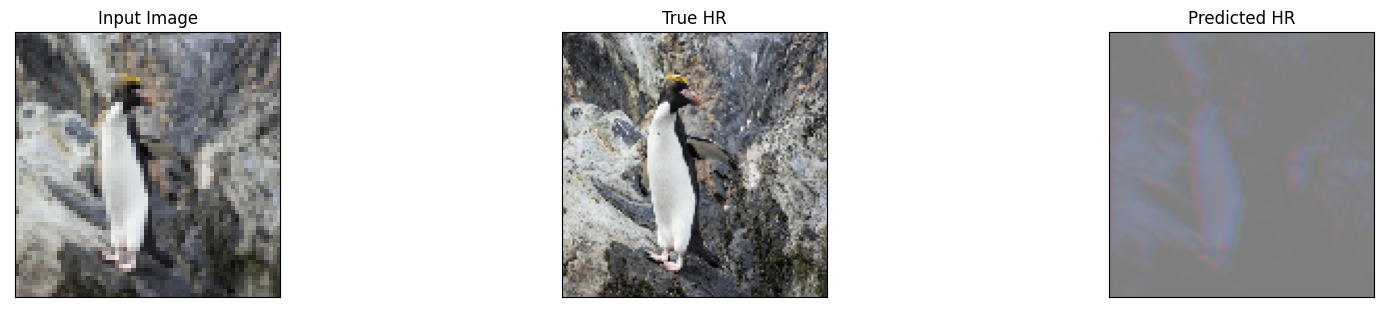

In [20]:
print_SRCNN(lr_images[0:1], hr_images[0:1])

In [21]:
filepath = 'srcnn.h5'
#saving model based on least amount of loss
checkpoint_SR = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [24]:
#training
history = model_SRCNN.fit(
    lr_images, hr_images, 
    epochs=35,
    validation_split=0.2,
    callbacks=[checkpoint_SR],
    batch_size = 16
        )

Epoch 1/35
5/5 [==============================] - ETA: 0s - loss: 0.2714 - accuracy: 0.4974
Epoch 1: loss improved from inf to 0.27141, saving model to srcnn.h5
5/5 [==============================] - 5s 648ms/step - loss: 0.2714 - accuracy: 0.4974 - val_loss: 0.2259 - val_accuracy: 0.5996
Epoch 2/35
5/5 [==============================] - ETA: 0s - loss: 0.2274 - accuracy: 0.5820
Epoch 2: loss improved from 0.27141 to 0.22741, saving model to srcnn.h5
5/5 [==============================] - 1s 278ms/step - loss: 0.2274 - accuracy: 0.5820 - val_loss: 0.2056 - val_accuracy: 0.6571
Epoch 3/35
5/5 [==============================] - ETA: 0s - loss: 0.2071 - accuracy: 0.5812
Epoch 3: loss improved from 0.22741 to 0.20707, saving model to srcnn.h5
5/5 [==============================] - 1s 278ms/step - loss: 0.2071 - accuracy: 0.5812 - val_loss: 0.1862 - val_accuracy: 0.6442
Epoch 4/35
5/5 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.5673
Epoch 4: loss improved from 0.

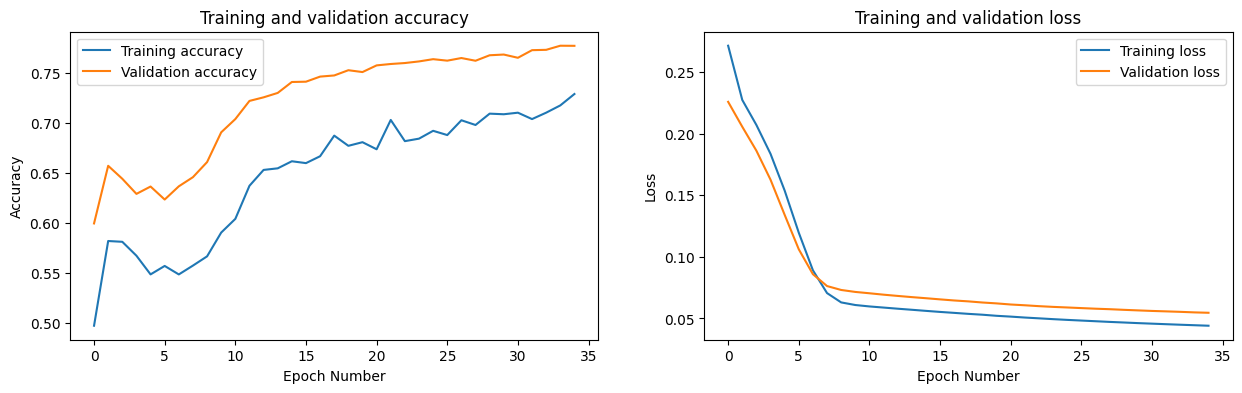

In [28]:
print_history(history)

In [29]:
model_SRCNN.save_weights('SRCNN')

In [ ]:
model_SRCNN.load_weights('SRCNN')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


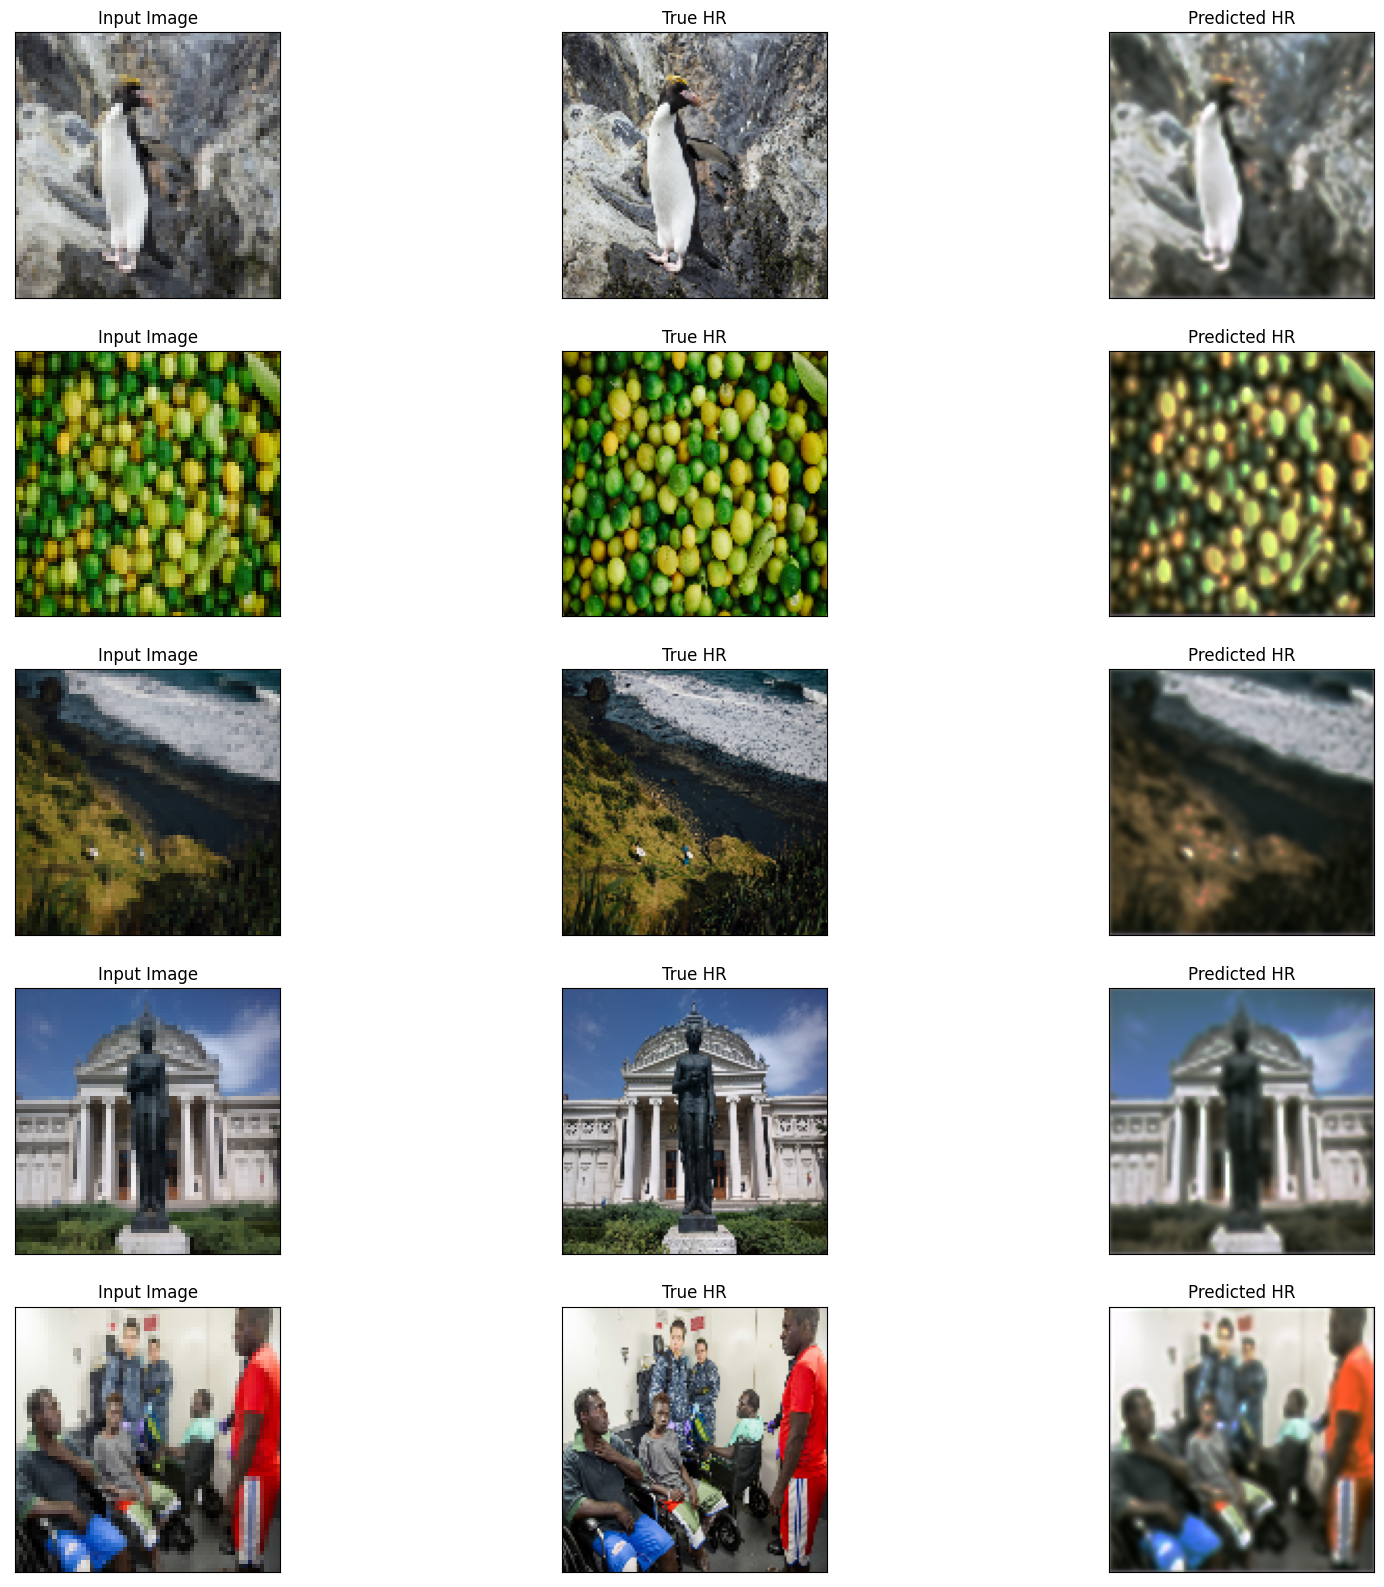

In [31]:
#example
print_SRCNN(lr_images[0:5], hr_images[0:5])

In [17]:
#loading in fish images and upscaling them
def load_images(image_path, mask_path):
    images = []
    masks = []
    for i in listdir(image_path):
        image = io.imread(image_path + "\\" + str(i))
        #image = color.rgba2rgb(image)
        image_res = resize(image,  (64, 64), anti_aliasing=False)
        image_res = image_res*2 - 1
        images.append(image_res)
    for i in listdir(mask_path):
        image = io.imread(mask_path + "\\" + str(i))
        #if image.shape != (64, 64, 3):
            #image = color.gray2rgb(image)
        image_res = resize(image,  (128, 128), anti_aliasing=False)
        masks.append(image_res)
    
    images=np.asarray(images).astype(np.float32)
    return images, masks

In [18]:
images, masks = load_images("fish\\image","fish\\mask")

In [ ]:
model_SRCNN.evaluate( ,images)

In [31]:
images = model_SRCNN.predict(images)

4/4 [==============================] - 1s 381ms/step


In [29]:
np.save('upscaled_images.npy', images)

In [13]:
#downscaling them by hand because my vram is not enough for 128x128 images
masks = []
for i in listdir("fish\\mask"):
    image = io.imread("fish\\mask" + "\\" + str(i))
    #if image.shape != (64, 64, 3):
        #image = color.gray2rgb(image)
    image_res = resize(image,  (96, 96), anti_aliasing=False)
    masks.append(image_res)
images = np.load('upscaled_images.npy')
images = np.clip(images, -1, 1)
images_96 = []
for image in images:
    image_res = resize(image,  (96, 96), anti_aliasing=False)
    images_96.append(image_res)
images=np.asarray(images_96).astype(np.float32)
masks=np.asarray(masks).astype(np.float32)

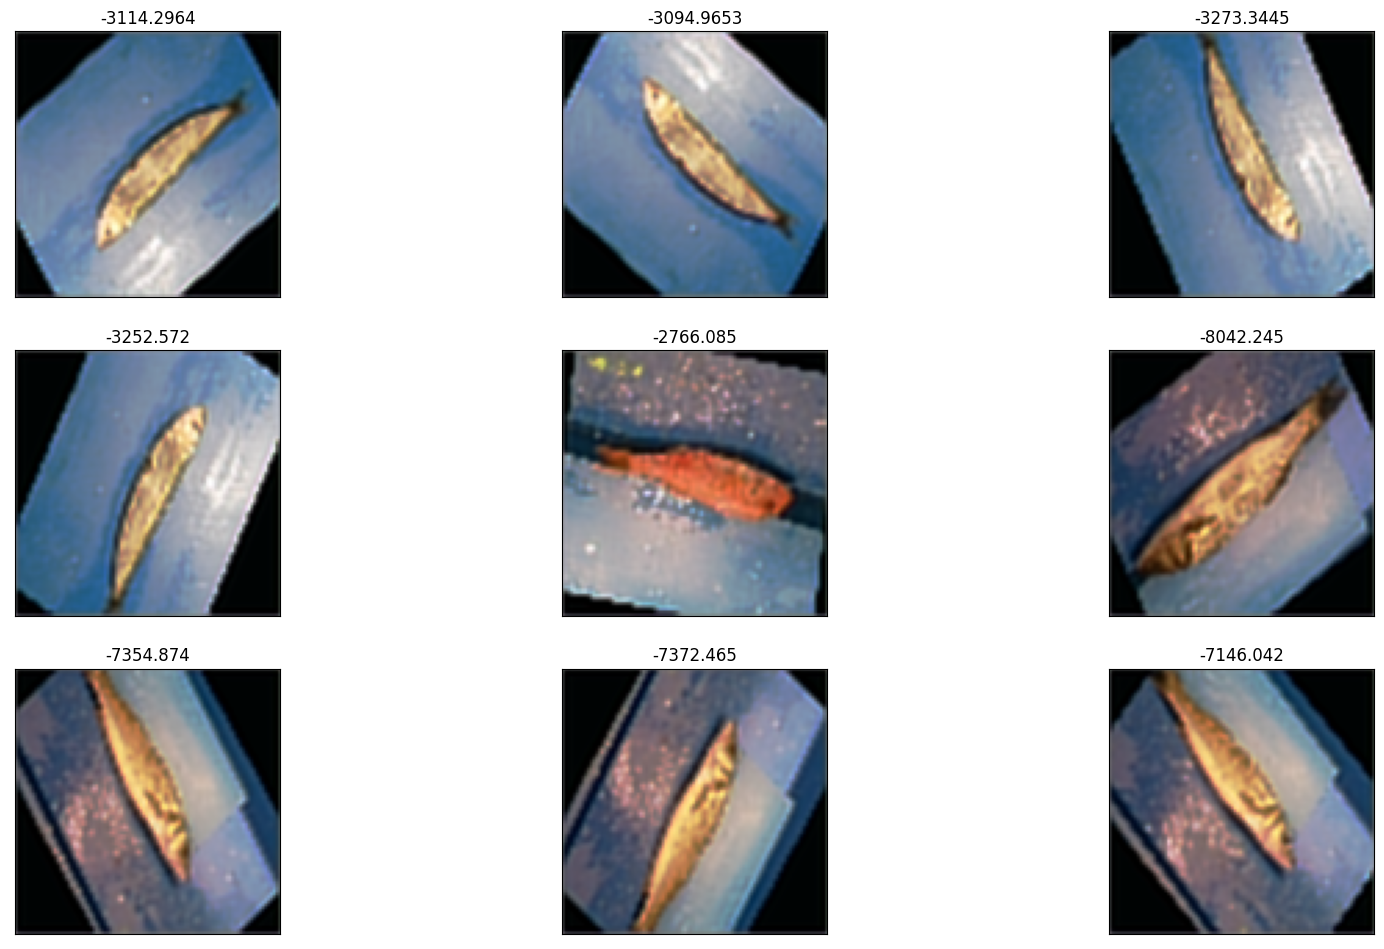

In [14]:
fig = plt.figure(figsize=(20,20))
for row in range(3):
    for column in range(3):
        i = row * 3 + column
        if i>len(images)-1:
            break                   
        ax = fig.add_subplot(5, 3, i+1)
        ax.set_title(str(np.sum(images[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((images[i]+1) / 2)

In [15]:
#same architecture, but input shape is different
def unet_model_2(optim):
    input_1 =  Input(shape=(96, 96, 3))
    conv_0 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(input_1)
    relu_0 = LeakyReLU(alpha=0.2)(conv_0)
    conv_0_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(relu_0)
    relu_0_1 = LeakyReLU(alpha=0.2)(conv_0_1)
    down_sample_1 = MaxPooling2D((2, 2))(relu_0_1) #96x96 -> 48x48
    conv_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(down_sample_1)
    relu_1 = LeakyReLU(alpha=0.2)(conv_1)
    conv_1_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(relu_1)
    relu_1_1 = LeakyReLU(alpha=0.2)(conv_1_1)
    down_sample_2 = MaxPooling2D((2, 2))(relu_1_1)  #48x48 -> 24x24
    conv_2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(down_sample_2)
    relu_2 = LeakyReLU(alpha=0.2)(conv_2)
    conv_2_1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(relu_2)
    relu_2_1 = LeakyReLU(alpha=0.2)(conv_2_1)
    relu_2_1 = Dropout(0.2)(relu_2_1)
    
    up_sample_1 = concatenate([UpSampling2D((2, 2))(relu_2_1), relu_1_1], axis=-1) #32x32
    up_conv_1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up_sample_1)
    up_relu_1 = LeakyReLU(alpha=0.2)(up_conv_1)    
    up_conv_1_1 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up_relu_1)
    up_relu_1_1 = LeakyReLU(alpha=0.2)(up_conv_1_1)
    
    up_sample_2 = concatenate([UpSampling2D((2, 2))(up_relu_1_1), relu_0_1], axis=-1) #64x64
    up_conv_2 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up_sample_2)
    up_relu_2 = LeakyReLU(alpha=0.2)(up_conv_2)    
    up_conv_2_1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up_relu_2)
    up_relu_2_1 = LeakyReLU(alpha=0.2)(up_conv_2_1)
    up_relu_2_1 = Dropout(0.2)(up_relu_2_1)
    
    output_1 = Conv2D(filters=1, kernel_size=(3, 3), padding="same")(up_relu_2_1)
    output_1 = LeakyReLU(alpha=0.2)(output_1)
    unet_model = Model(inputs = input_1, outputs = output_1)
    unet_model.compile(optimizer = optim, loss = 'binary_crossentropy', metrics = ['accuracy'])
    return unet_model


In [17]:
model = unet_model_2(optim)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_11 (Conv2D)             (None, 96, 96, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 leaky_re_lu_11 (LeakyReLU)     (None, 96, 96, 64)   0           ['conv2d_11[0][0]']              
                                                                                                  
 conv2d_12 (Conv2D)             (None, 96, 96, 64)   36928       ['leaky_re_lu_11[0][0]']         
                                                                                            

In [12]:
#checking shape
images.shape

(111, 96, 96, 3)

In [13]:
#training
filepath = 'fishmodel128.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')

In [14]:
history = model.fit(
    images, masks, 
    epochs=40,
    validation_split=0.2,
    callbacks=[checkpoint],
    batch_size = 16
    #steps_per_epoch=4
        )

Epoch 1/40


N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


6/6 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.8781
Epoch 1: accuracy improved from -inf to 0.87815, saving model to fishmodel128.h5
6/6 [==============================] - 8s 681ms/step - loss: 0.5618 - accuracy: 0.8781 - val_loss: 0.3473 - val_accuracy: 0.8292
Epoch 2/40
6/6 [==============================] - ETA: 0s - loss: 0.2572 - accuracy: 0.8808
Epoch 2: accuracy improved from 0.87815 to 0.88084, saving model to fishmodel128.h5
6/6 [==============================] - 2s 304ms/step - loss: 0.2572 - accuracy: 0.8808 - val_loss: 0.2224 - val_accuracy: 0.9012
Epoch 3/40
6/6 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9353
Epoch 3: accuracy improved from 0.88084 to 0.93535, saving model to fishmodel128.h5
6/6 [==============================] - 2s 302ms/step - loss: 0.1817 - accuracy: 0.9353 - val_loss: 0.7267 - val_accuracy: 0.7480
Epoch 4/40
6/6 [==============================] - ETA: 0s - loss: 0.3924 - accuracy: 0.8575
Epoch 4

In [23]:
imagelist = [images[5], images[16], images[30]]
masklist = [masks[5], masks[16], masks[30]]
imagelist = np.asarray(imagelist).astype(np.float32)
masklist = np.asarray(masklist).astype(np.float32)

N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


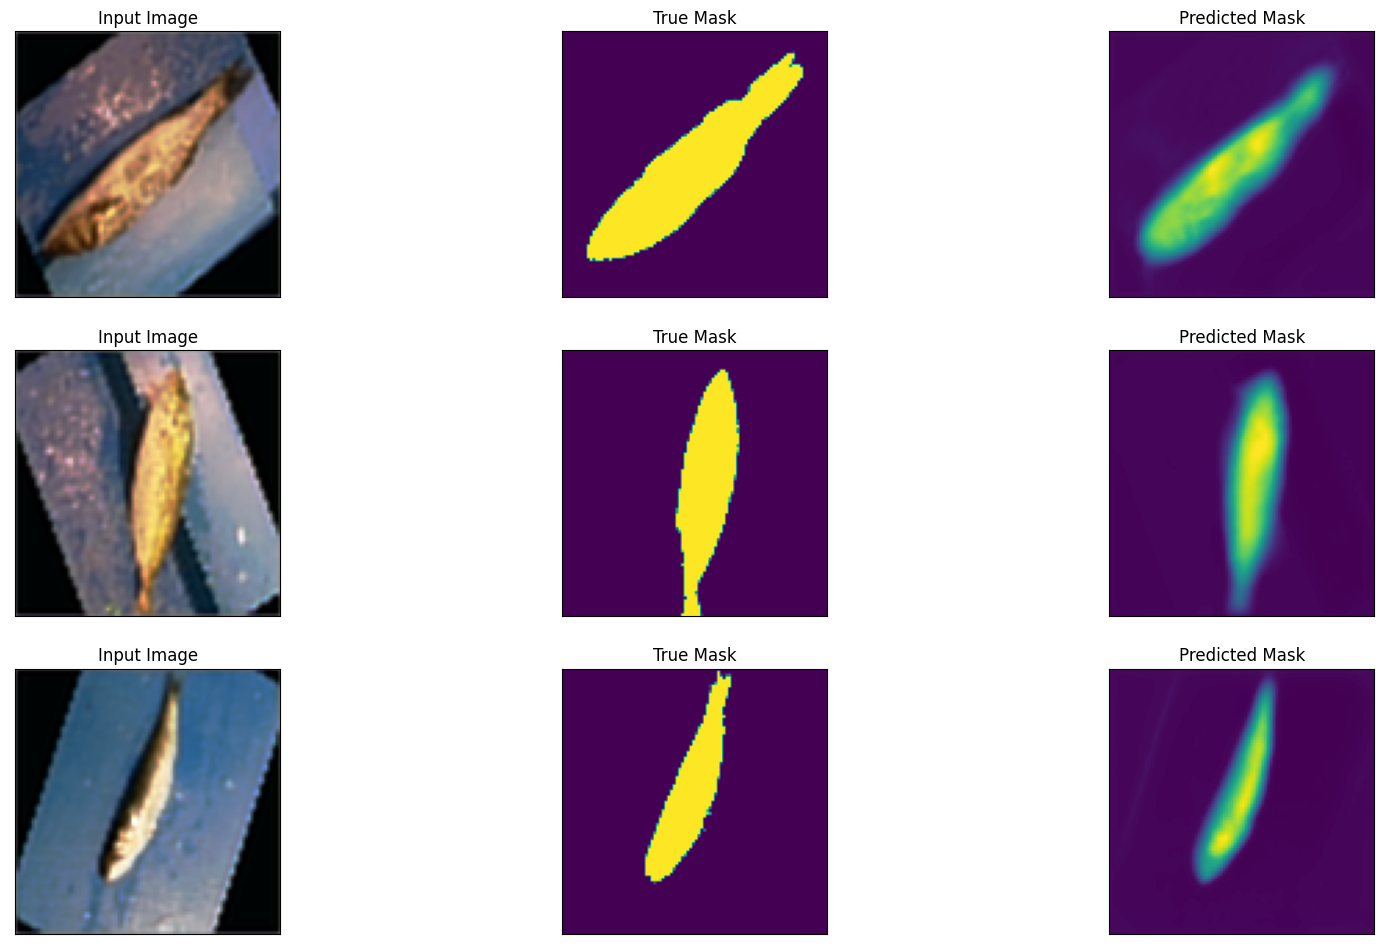

In [24]:
print_prediction(imagelist, masklist)

In [25]:
print_history(history)

NameError: name 'print_history' is not defined

In [23]:
model.save_weights('96FISH')

In [19]:
model.load_weights('96FISH')

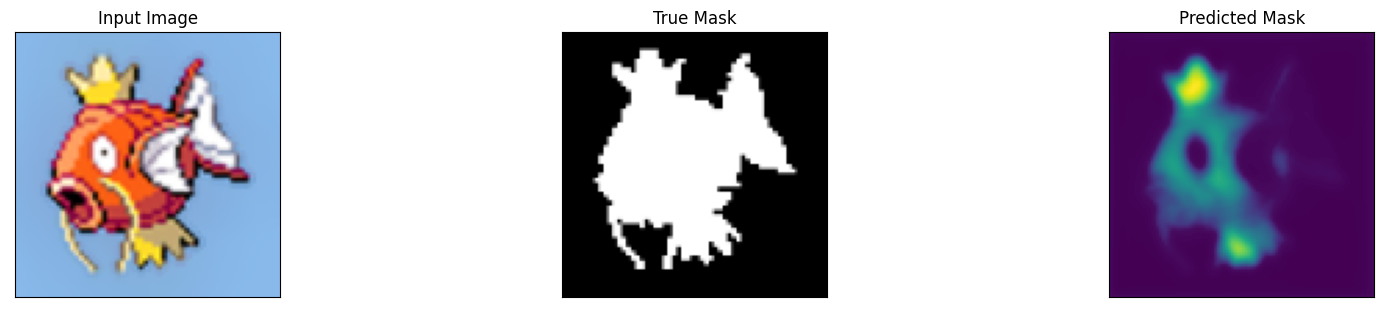

In [26]:
#checking on unrelated images again
image = io.imread("fish\\00003.png")
image = color.rgba2rgb(image)
image_res = resize(image,  (96, 96), anti_aliasing=False)
imask = io.imread("fish\\00003m.png")
imask = resize(imask,  (96, 96), anti_aliasing=False)
print_prediction(np.asarray([(image_res*2-1)]).astype(np.float32), np.asarray([imask]).astype(np.float32))

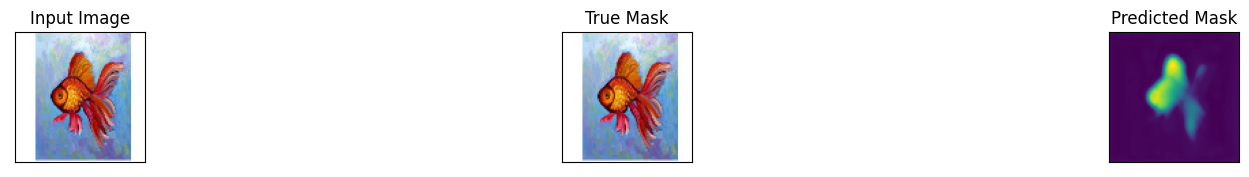

In [22]:
image = io.imread("fish\\fish.jpg")
#image = color.rgba2rgb(image)
image_res = resize(image,  (96, 96), anti_aliasing=False)
print_prediction(np.asarray([(image_res*2-1)]).astype(np.float32), np.asarray([image_res]).astype(np.float32))

In [29]:
image_path, mask_path = "fish\\test1","fish\\test1mask"
images = []
for i in listdir(image_path):
    image = io.imread(image_path + "\\" + str(i))
    #image = color.rgba2rgb(image)
    image_res = resize(image,  (64, 64), anti_aliasing=False)
    image_res = image_res*2 - 1
    images.append(image_res)
    
images=np.asarray(images).astype(np.float32)
#images = model_SRCNN.predict(images)

In [14]:
images34 = model_SRCNN.predict(images[0:-30])

1/1 [==============================] - 1s 1s/step


In [21]:
#i could process 111 pictures at the same time but can't do so with 54 for some reason
np.save('upscaled_images_test-30.npy', images34)

In [16]:
images34 = np.load('upscaled_images_test-30.npy')

In [21]:
tf.keras.backend.clear_session()

In [15]:
images54 = model_SRCNN.predict(images[-30:])


N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 6s 6s/step


In [22]:
images = np.concatenate((images34, images54))
images.shape

(54, 128, 128, 3)

In [21]:
np.save('upscaled_images_test.npy', images)

In [11]:
masks = []
for i in listdir("fish\\test1mask"):
    image = io.imread("fish\\test1mask" + "\\" + str(i))
    #if image.shape != (64, 64, 3):
        #image = color.gray2rgb(image)
    image_res = resize(image,  (96, 96), anti_aliasing=False)
    masks.append(image_res)
images = np.load('upscaled_images_test.npy')
images = np.clip(images, -1, 1)
images_96 = []
for image in images:
    image_res = resize(image,  (96, 96), anti_aliasing=False)
    images_96.append(image_res)
images=np.asarray(images_96).astype(np.float32)
masks=np.asarray(masks).astype(np.float32)

In [31]:
#getting adv patterns. 10 at a time.
gradient1 = create_adversarial_pattern(images[0:10], masks[0:10])

In [32]:
gradient2 = create_adversarial_pattern(images[10:20], masks[10:20])

In [33]:
gradient3 = create_adversarial_pattern(images[20:30], masks[20:30])

In [34]:
gradient4 = create_adversarial_pattern(images[30:40], masks[30:40])

In [35]:
gradient5 = create_adversarial_pattern(images[40:50], masks[40:50])

In [36]:
gradient6 = create_adversarial_pattern(images[50:54], masks[50:54])

In [37]:
gradient1 = np.asarray(gradient1).astype(np.float32)
gradient2 = np.asarray(gradient2).astype(np.float32)
gradient3 = np.asarray(gradient3).astype(np.float32)
gradient = np.concatenate((gradient1, gradient2, gradient3))
np.save('gradient1.npy', gradient)

In [38]:
gradient4 = np.asarray(gradient4).astype(np.float32)
gradient5 = np.asarray(gradient5).astype(np.float32)
gradient6 = np.asarray(gradient6).astype(np.float32)
gradient = np.concatenate((gradient4, gradient5, gradient6))
np.save('gradient2.npy', gradient)

In [39]:
gradient = np.concatenate((np.load('gradient1.npy'),np.load('gradient2.npy')))

In [22]:
gradient.shape

(54, 96, 96, 3)

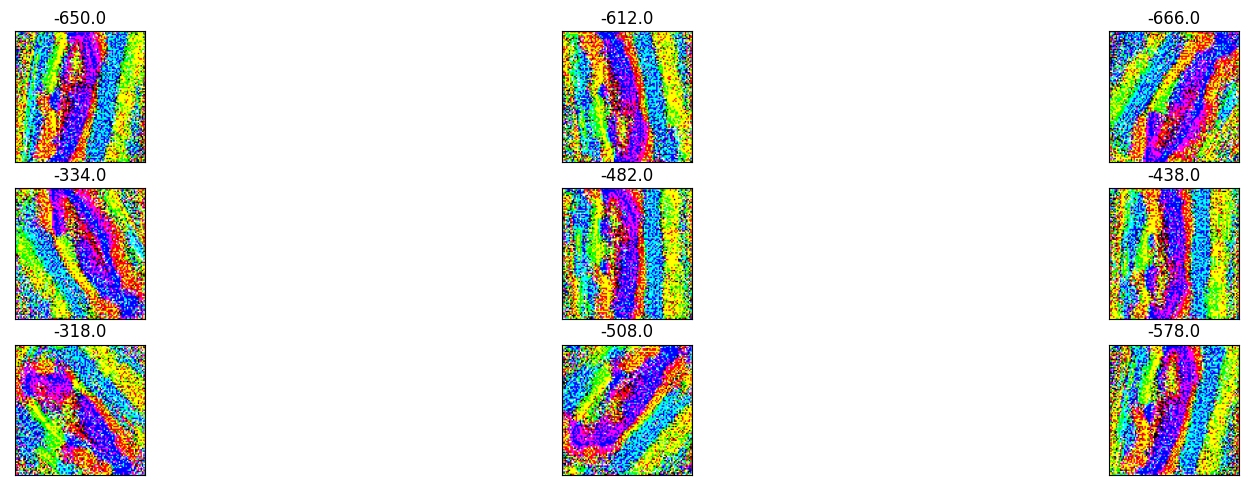

In [40]:
fig = plt.figure(figsize=(20,20))
for row in range(3):
    for column in range(3):
        i = row * 3 + column
        if i>len(images)-1:
            break                   
        ax = fig.add_subplot(5, 3, i+1)
        ax.set_title(str(np.sum(gradient[i])))     
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow((gradient[i]+1)/2)

In [41]:
epsilons = [0, 0.01, 0.1, 0.15]
adversarials = []
for i, eps in enumerate(epsilons):
    adversarials.append(np.clip(images + eps*gradient, -1, 1))

In [42]:
np.save('adversarials_test.npy', np.asarray(adversarials).astype(np.float32))

In [12]:
adversarials = np.load('adversarials_test.npy')

N:\python_dataset\pythonNeuralNet\venv\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2/2 [==============================] - 0s 110ms/step - loss: 1.6406 - accuracy: 0.8139


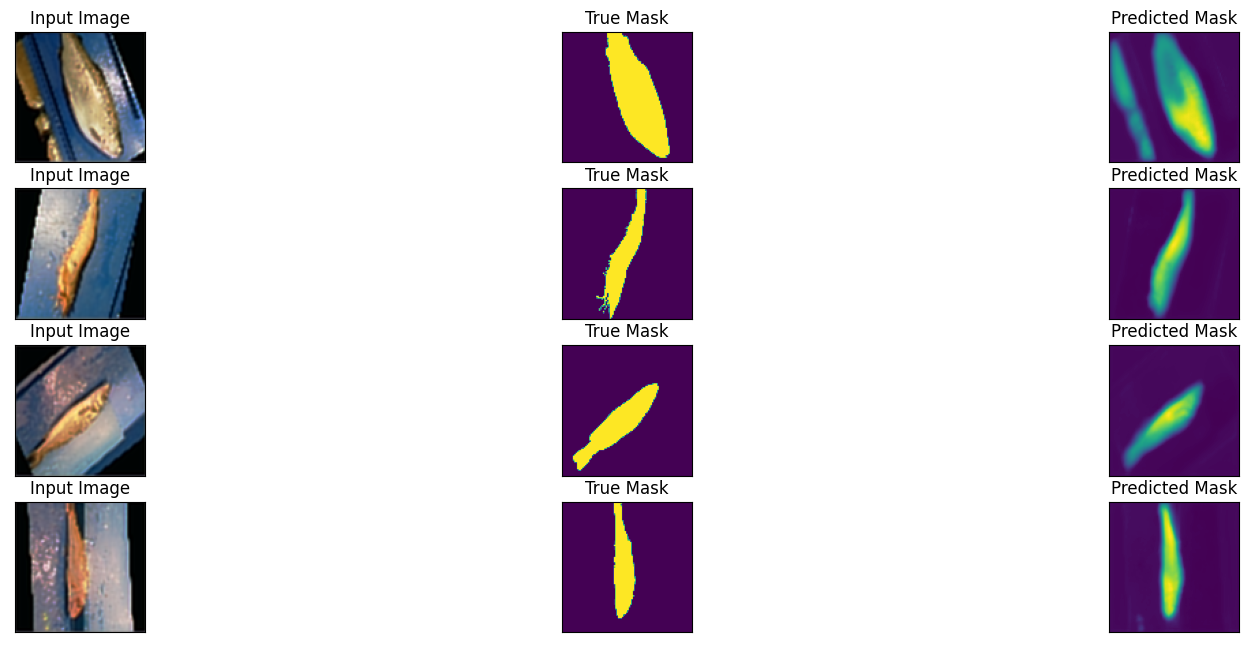

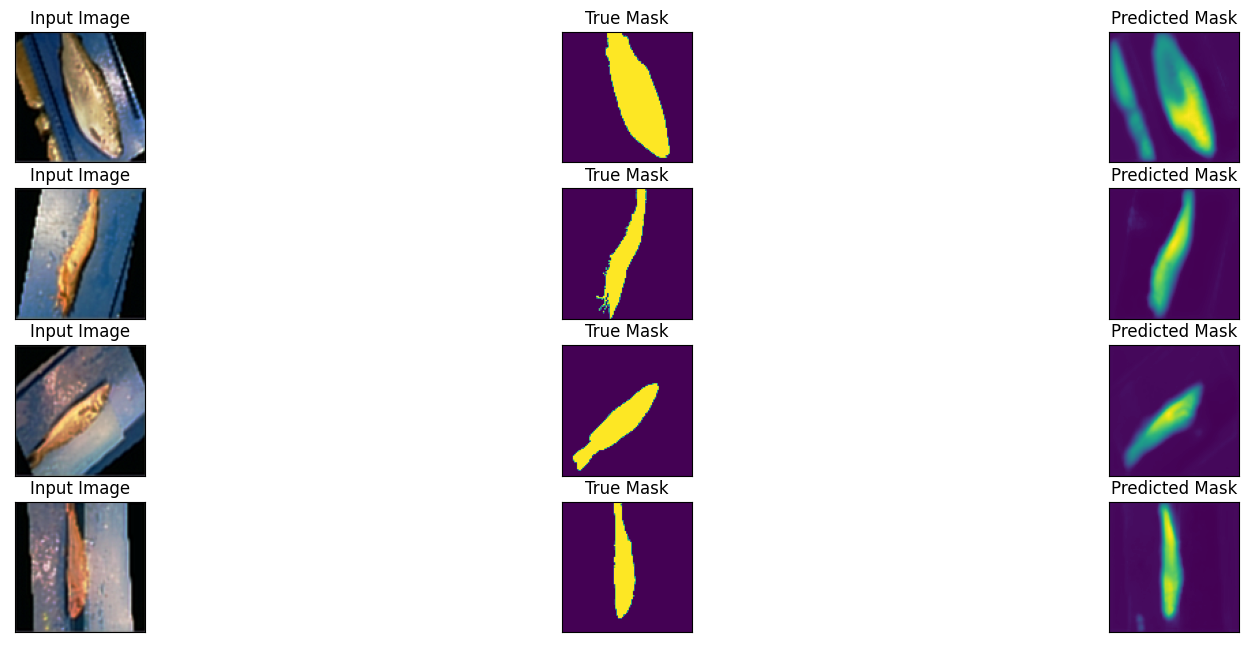

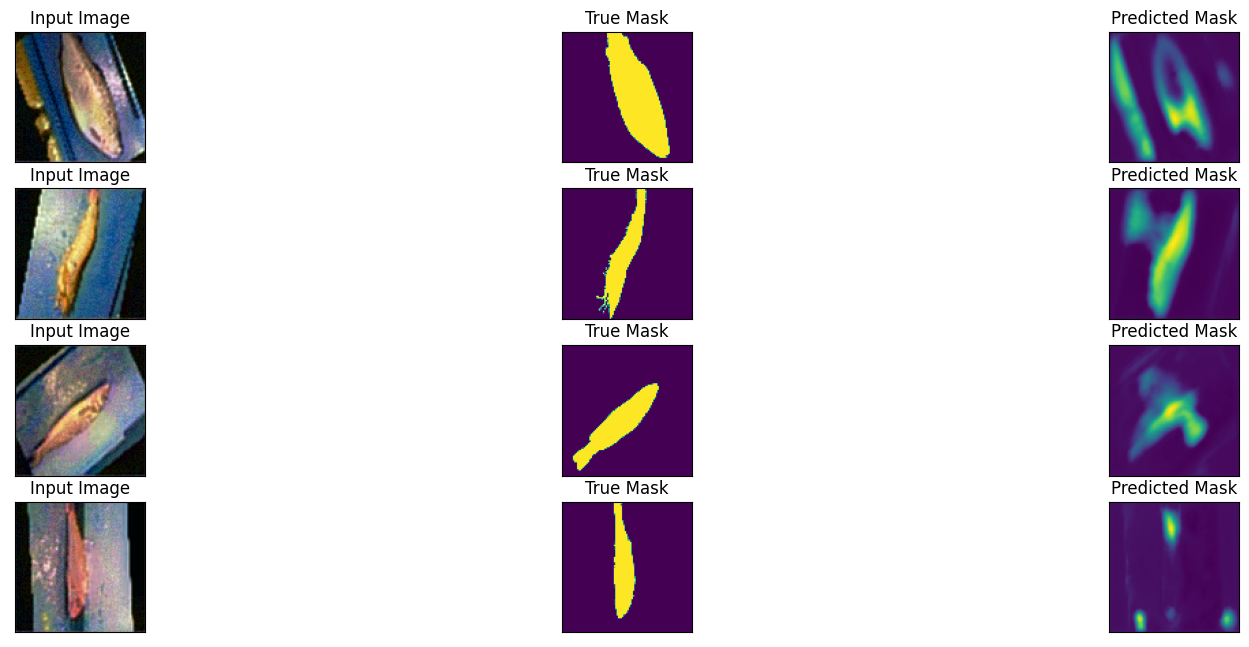

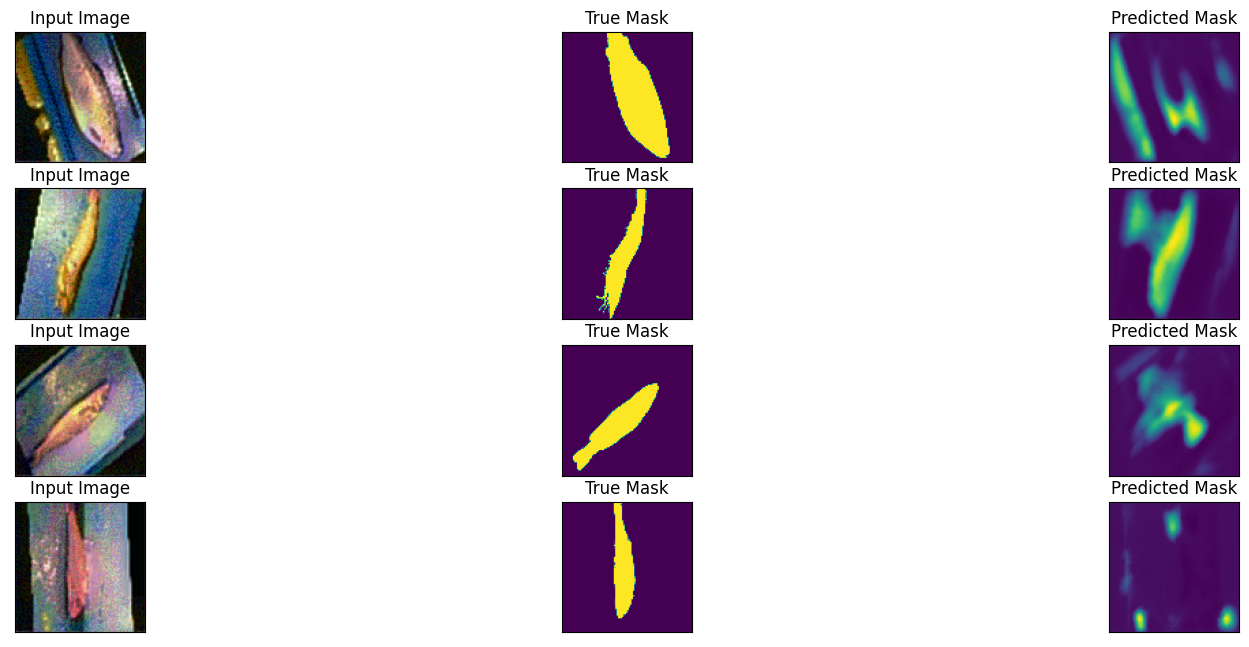

In [13]:
#it works better with 96x96 pictures.
for i in range(len(adversarials)):
    model.evaluate(adversarials[i], masks)
for i in range(len(adversarials)):
    print_prediction((adversarials[i])[12:16], masks[12:16])

Fish dataset: https://www.kaggle.com/datasets/crowww/a-large-scale-fish-dataset

Dataset for SRCNN: https://www.kaggle.com/datasets/akhileshdkapse/super-image-resolution